In [1]:
# Standard libraries
import os
import sys
import json
import random
import logging
import numpy as np
import matplotlib.pyplot as plt

# Third-party libraries
from tqdm import tqdm
from torchsummary import summary

# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

# PyTorch learning rate schedulers
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# PyTorch utilities
from torchvision.utils import make_grid

# Project-specific modules
from autoencoder.autoencoder import *
from PARCv1.differentiator import *
from PARCtorch.integrator.rk4 import *
from PARCtorch.integrator.numintegrator import *
from LatentPARC_model import *
from model_analysis import *

##### Update version of PARCtorch

download file below from github, upload to home directory, then run code below

!pip install /home/pdy2bw/PARCtorch-0.3.0-py3-none-any.whl

# Load in Data Paths and Functions

In [2]:
# get PARCtorch path
path = os.path.abspath(os.path.join(os.getcwd(), "..")) 
print(path)

# Add the root directory (PARCTorch) to the system path
sys.path.append(path)
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth
from data.normalization import compute_min_max

# Get single void HMX data
data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/HMX/train",
    "/project/vil_baek/data/physics/PARCTorch/HMX/test",
]
output_file = path + "/data/hmx_min_max.json"
compute_min_max(data_dirs, output_file)

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/HMX/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/HMX/test"  # Replace with your actual test directory path

# Path to the min_max.json file
min_max_path = os.path.join(path, "data", "hmx_min_max.json")  # Correct path

/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch
Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC
Total files to process: 133
Processed 100/133 files.
Processed 133/133 files.
Channel-wise min values: [300.0, -1186907500.0, 0.0, -1995.0012, -5521.5503]
Channel-wise max values: [5000.0, 69721220000.0, 1.0, 7184.0073, 5215.695]
Min and max values saved to '/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/hmx_min_max.json'.


# Create Data Loader for Training

In [3]:
n_ts = 2 # do 2 for single ts (1 future ts which is target)
batch_size = 32
validation_split = 0.05  # 5% for validation

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

# Calculate the size of the validation set
validation_size = int(len(train_dataset) * validation_split)
train_size = len(train_dataset) - validation_size

# Perform the split
train_subset, val_subset = random_split(train_dataset, [train_size, validation_size])

# Create DataLoader for training and validation datasets
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the training data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2025-05-09 10:33:36,295 [INFO] Starting data validation...
2025-05-09 10:33:36,299 [INFO] Validating .npy files...
Validating files: 100%|██████████| 100/100 [00:06<00:00, 14.67it/s]
2025-05-09 10:33:43,123 [INFO] Data validation completed successfully.
2025-05-09 10:33:43,124 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 100/100 [00:02<00:00, 44.44it/s]
2025-05-09 10:33:45,379 [INFO] Total samples in dataset: 1400


# Define LatentPARC Architecture + Training

In [4]:
# where to save weights
save_path="/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC"
weights_name="test"

# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes_T = [1, 2]
latent_dim_T = 2
layer_sizes_P = [1, 2]
latent_dim_P = 2
layer_sizes_M = [1, 2]
latent_dim_M = 2

latent_dim = latent_dim_T + latent_dim_P + latent_dim_M # 12

encoder_T = Encoder(layers=layer_sizes_T, latent_dim=latent_dim_T).to(device)
encoder_P = Encoder(layers=layer_sizes_P, latent_dim=latent_dim_P).to(device)
encoder_M = Encoder(layers=layer_sizes_M, latent_dim=latent_dim_M).to(device)
decoder_T = Decoder(layers=layer_sizes_T, latent_dim=latent_dim_T).to(device)
decoder_P = Decoder(layers=layer_sizes_P, latent_dim=latent_dim_P).to(device)
decoder_M = Decoder(layers=layer_sizes_M, latent_dim=latent_dim_M).to(device)

differentiator = Differentiator(latent_dim=latent_dim)
integrator = RK4().to(device)  # step size may be hyper-param of interest

In [5]:
# ONLY RUN IF LOADING PRETRAINED WEIGHTS TO AE
# !!!! If this works, modify AE code to save encoder and decoder weights separate for simplicity
AE_weights_path = "autoencoder/3enc_3dec_vertflip_ReLU_normal_conv_ReLU_out_layers_1_2_latent_6_MAE_DE_Nmax16_nrf8_redon500_LRstep_e3_factor8_stepsize200_3000.pth"
ckpt = torch.load(AE_weights_path, map_location=device)

# Load encoder weights
encoder_T.load_state_dict({k.replace('encoderT.', ''): v for k, v in ckpt.items() if k.startswith('encoderT.')})
encoder_P.load_state_dict({k.replace('encoderP.', ''): v for k, v in ckpt.items() if k.startswith('encoderP.')})
encoder_M.load_state_dict({k.replace('encoderM.', ''): v for k, v in ckpt.items() if k.startswith('encoderM.')})

# Load decoder weights
decoder_T.load_state_dict({k.replace('decoderT.', ''): v for k, v in ckpt.items() if k.startswith('decoderT.')})
decoder_P.load_state_dict({k.replace('decoderP.', ''): v for k, v in ckpt.items() if k.startswith('decoderP.')})
decoder_M.load_state_dict({k.replace('decoderM.', ''): v for k, v in ckpt.items() if k.startswith('decoderM.')})

################################################
# OPTIONAL: Freeze AE weights
for module in [encoder_T, encoder_P, encoder_M, decoder_T, decoder_P, decoder_M]:
    for param in module.parameters():
        param.requires_grad = False
################################################

/tmp/ipykernel_39090/2489998950.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(AE_weights_path, map_location=device)


In [6]:
# Initialize LatentPARC
model_init = lp_model_3encoder_3decoder(encoder_T, encoder_P, encoder_M, decoder_T,
                                        decoder_P, decoder_M, differentiator, 
                                        integrator).to(device)

#Loss Function
criterion = torch.nn.L1Loss().to(device)
# criterion = LpLoss(p=10).cuda()
# criterion = nn.MSELoss()

optimizer = Adam(model_init.parameters(), lr=1e-3)

# Define learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=True)

#  training model
model = LatentPARC(model_init, optimizer, save_path, weights_name)

log_dict = model.train(criterion, epochs=10, image_size = [128, 256], n_channels=3, device=device, 
                       train_loader=train_loader, val_loader=val_loader, scheduler=scheduler,
                       noise_fn=add_random_noise, initial_max_noise=0.16, n_reduce_factor=0.5, 
                       ms_reduce_factor=0, reduce_on=3, mode="single_ts_train")

/home/pdy2bw/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10


Validating: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


Epoch 1: Training Loss: 0.1337 | Validation Loss: 0.1606

Epoch 2/10


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


Epoch 2: Training Loss: 0.1017 | Validation Loss: 0.1547

Epoch 3/10


Validating: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


Epoch 3: Training Loss: 0.0771 | Validation Loss: 0.1134

Epoch 4/10


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.41it/s]


Epoch 4: Training Loss: 0.0688 | Validation Loss: 0.1055

Epoch 5/10


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch 5: Training Loss: 0.0653 | Validation Loss: 0.1011

Epoch 6/10


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]


Epoch 6: Training Loss: 0.0576 | Validation Loss: 0.0683

Epoch 7/10


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.69it/s]


Epoch 7: Training Loss: 0.0520 | Validation Loss: 0.0708

Epoch 8/10


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]


Epoch 8: Training Loss: 0.0509 | Validation Loss: 0.0675

Epoch 9/10


Validating: 100%|██████████| 3/3 [00:00<00:00,  7.01it/s]


Epoch 9: Training Loss: 0.0453 | Validation Loss: 0.0561

Epoch 10/10


Validating: 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

Epoch 10: Training Loss: 0.0436 | Validation Loss: 0.0536


Model and logs saved to /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC


# Load in weights

In [3]:
# define model
# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes_T = [1, 2]
latent_dim_T = 2
layer_sizes_P = [1, 2]
latent_dim_P = latent_dim_T
layer_sizes_M = [1, 2]
latent_dim_M = latent_dim_T

latent_dim = latent_dim_T + latent_dim_P + latent_dim_M

encoder_T = Encoder(layers=layer_sizes_T, latent_dim=latent_dim_T).to(device)
encoder_P = Encoder(layers=layer_sizes_P, latent_dim=latent_dim_P).to(device)
encoder_M = Encoder(layers=layer_sizes_M, latent_dim=latent_dim_M).to(device)
decoder_T = Decoder(layers=layer_sizes_T, latent_dim=latent_dim_T).to(device)
decoder_P = Decoder(layers=layer_sizes_P, latent_dim=latent_dim_P).to(device)
decoder_M = Decoder(layers=layer_sizes_M, latent_dim=latent_dim_M).to(device)
differentiator = Differentiator(latent_dim=latent_dim)
integrator = RK4().to(device)  # step size may be hyper-param of interest

# Initialize LatentPARC
model_init = lp_model_3encoder_3decoder(encoder_T, encoder_P, encoder_M, decoder_T,
                                        decoder_P, decoder_M, differentiator, 
                                        integrator).to(device)

# Initialize Optimizer
optimizer = Adam(model_init.parameters(), lr=1e-3)

# Initialize Full Model
model = LatentPARC(model_init, optimizer)

In [4]:
# load weights into model
weights_path = "rollout_train_nts_5_FROZEN_3enc_3dec_vertflip_ReLU_normal_conv_ReLU_out_layers_1_2_latent_6_NONOISE_LRplateau_factor8_pat10_1000.pth"

model.network.load_state_dict(torch.load(weights_path))
model.network.eval()  # Set to evaluation mode

/tmp/ipykernel_245952/2067670850.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.network.load_state_dict(torch.load(weights_path))


lp_model_3encoder_3decoder(
  (encoderT): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (encoderP): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (encoderM): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoderT): Decoder(
    (conv): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode='bilinear')
      (4): Conv2d(2, 1, kernel_size=(3, 3), stride

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model.network)}")

Total trainable parameters: 1261759


##### PARCv1 has 17,852,019 params total with 15,384,870 of those in the U-net shape descriptor, so PARCv1 differentiator is 2,467,149 params which is ~2x more than LatentPARC 2x version at 1,272,835

# Make Predictions

### Load in Test Data

In [5]:
# load in test dataset with full 15ts sequence
n_channels = 3
n_ts = 15

# Create test dataset
# ic, t0, t1, gt
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test], #test
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

2025-05-21 10:03:19,973 [INFO] Starting data validation...
2025-05-21 10:03:19,977 [INFO] Validating .npy files...
Validating files: 100%|██████████| 33/33 [00:00<00:00, 605.23it/s]
2025-05-21 10:03:20,038 [INFO] Data validation completed successfully.
2025-05-21 10:03:20,039 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 33/33 [00:00<00:00, 426.16it/s]
2025-05-21 10:03:20,122 [INFO] Total samples in dataset: 33


In [6]:
sample_id = 0
ic, _, ts, target = test_dataset[sample_id]
ic = ic[:n_channels, ...]
target = target[:, :n_channels, ...]
print(ic.shape, target.shape)
X = torch.concat((ic.unsqueeze(0), target))
print(X.shape)

torch.Size([3, 128, 256]) torch.Size([14, 3, 128, 256])
torch.Size([15, 3, 128, 256])


# Single ts preds

In [7]:
just_AE_reconstruction_pred = []
single_ts_Zhat = []
single_ts_full_reconstruction_pred = []

for i in range(n_ts-1): #!!! test
    IC = X[i, ...].unsqueeze(0).to(device)
    target = X[i+1, ...].unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Reconstructing test images
        _, x_bar = model.network(IC, n_ts=0) # just AE
        z_hat, x_hat = model.network(IC, n_ts=1) # AE + dynamics
        
    # Sending reconstructed and original images to CPU and accumulating in lists
    just_AE_reconstruction_pred.append(x_bar.cpu())
    single_ts_Zhat.append(z_hat.cpu())
    single_ts_full_reconstruction_pred.append(x_hat.cpu())

# Concatenate all batches to create single tensors
just_AE_reconstruction_pred = torch.cat(just_AE_reconstruction_pred, dim=0)

single_ts_Zhat = torch.cat(single_ts_Zhat, dim=0)  # Shape: (total_images, n_channels, height, width)

single_ts_full_reconstruction_pred = torch.cat(single_ts_full_reconstruction_pred, dim=0)
single_ts_full_reconstruction_pred = torch.concat([X[0, ...].unsqueeze(0), single_ts_full_reconstruction_pred])

In [8]:
single_ts_full_reconstruction_pred.shape, just_AE_reconstruction_pred.shape, single_ts_Zhat.shape

(torch.Size([15, 3, 128, 256]),
 torch.Size([14, 3, 128, 256]),
 torch.Size([14, 6, 32, 64]))

### AE Reconstruction Evaluation

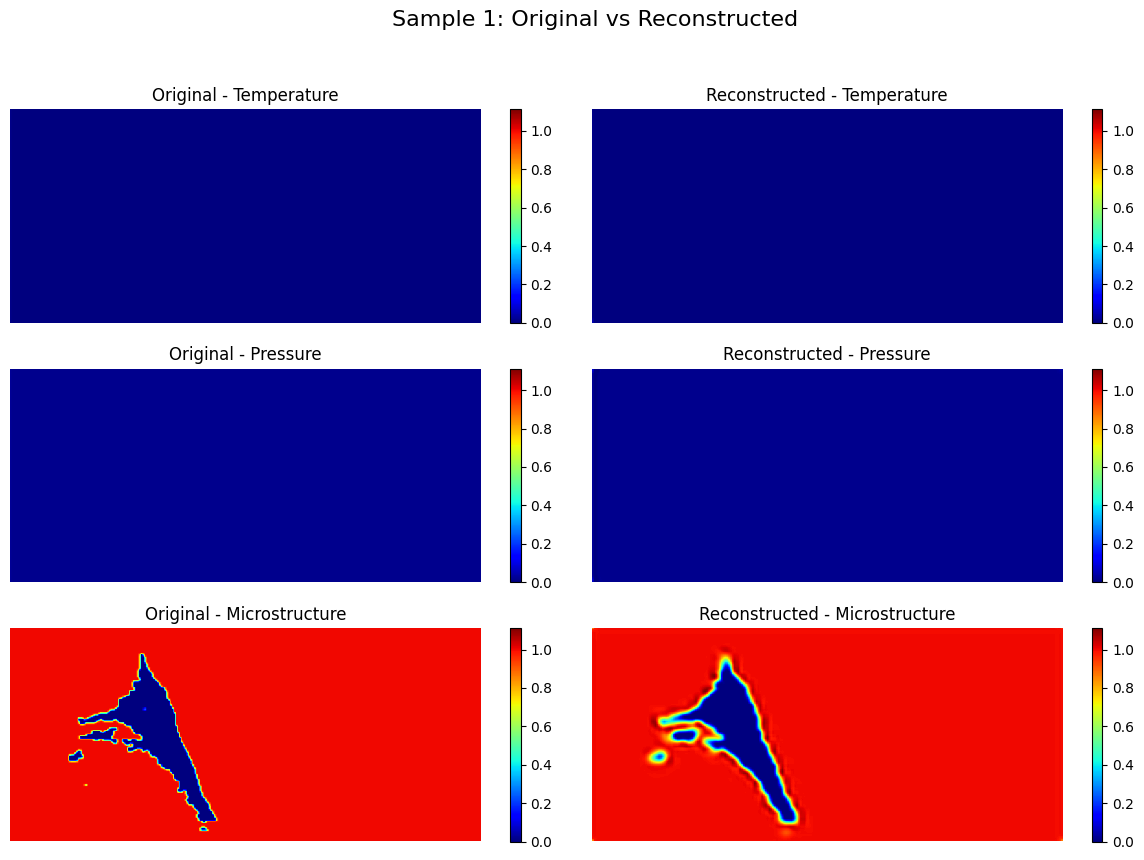

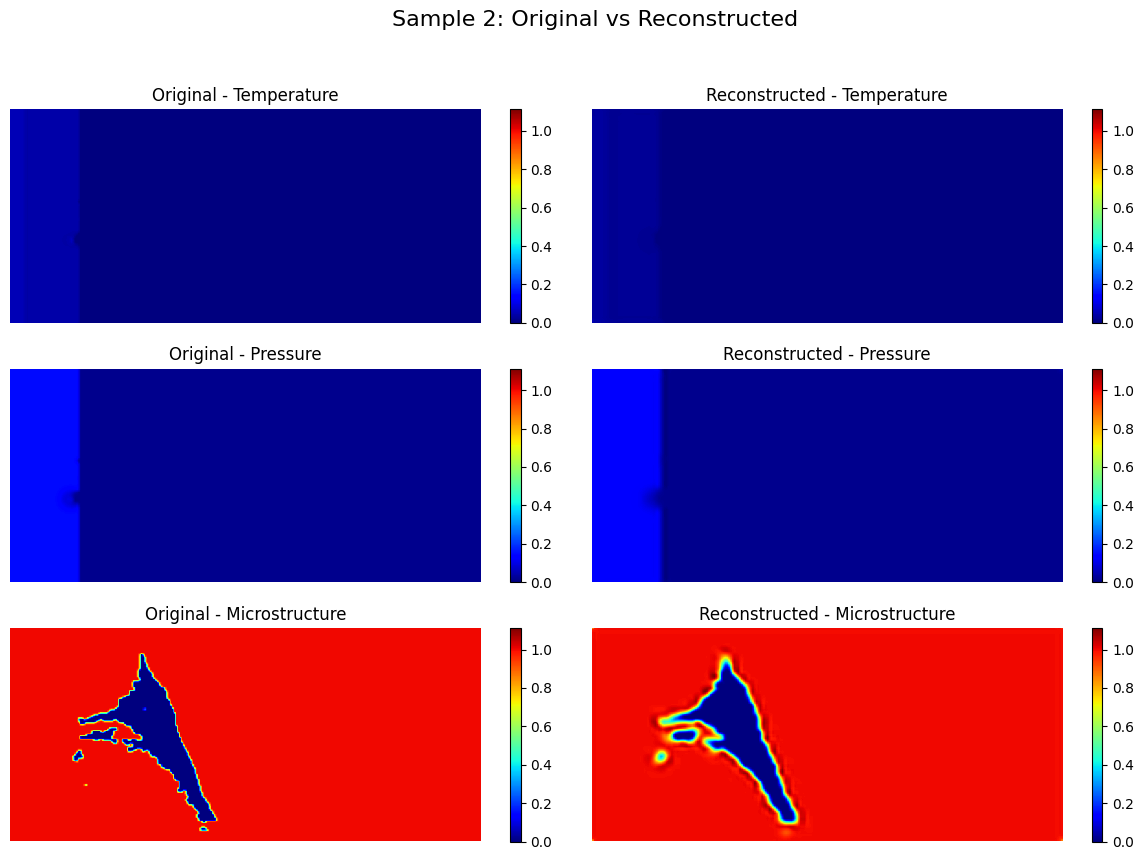

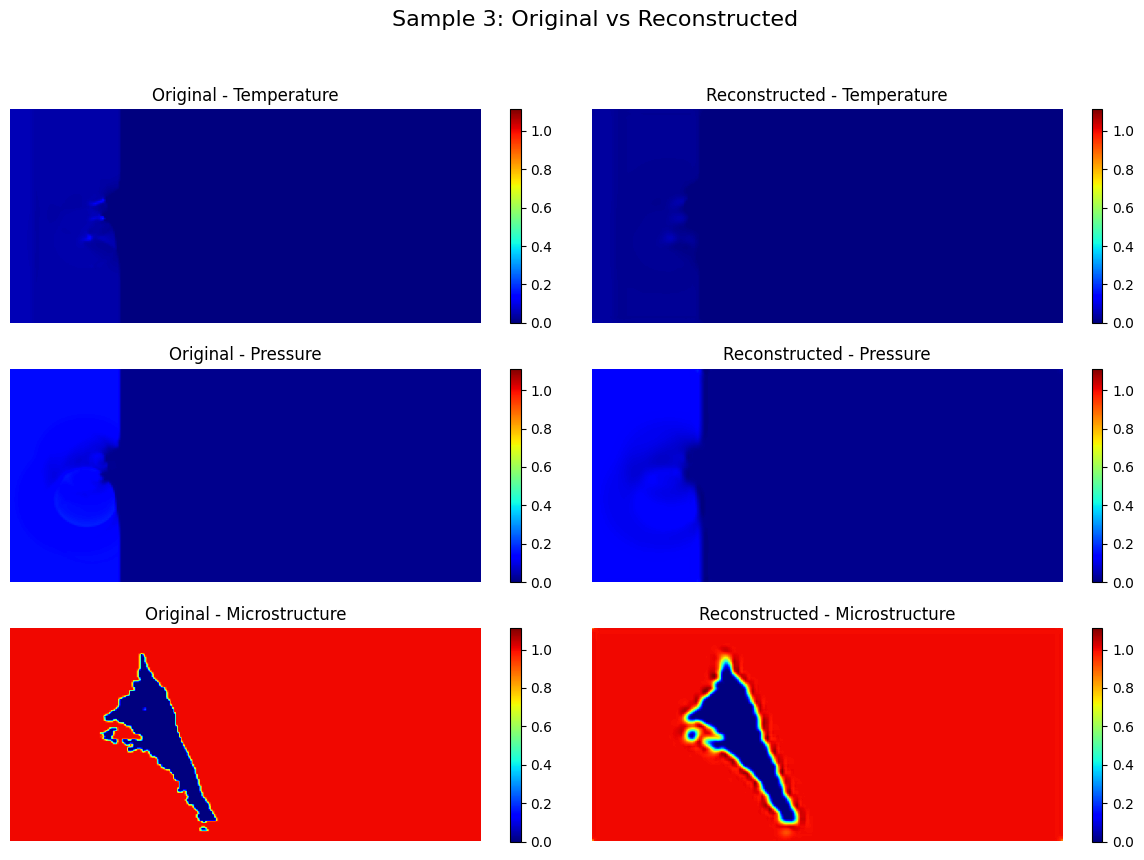

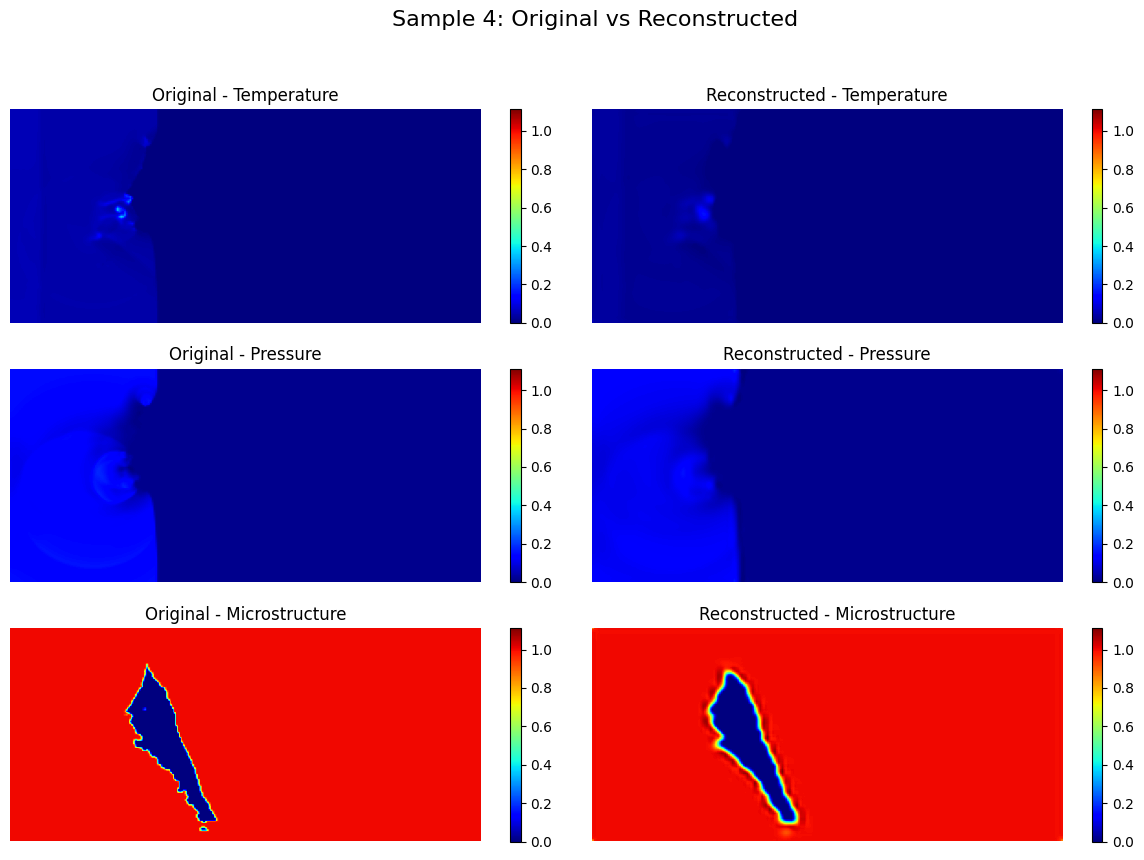

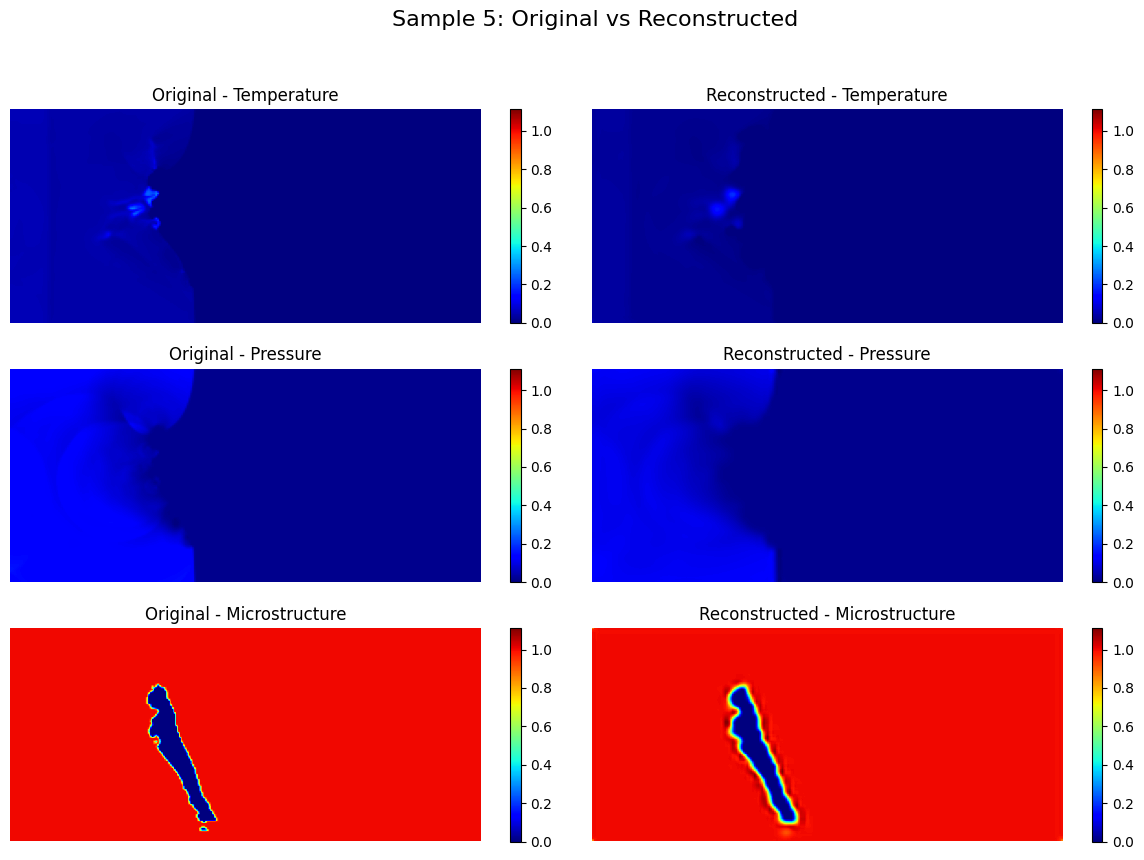

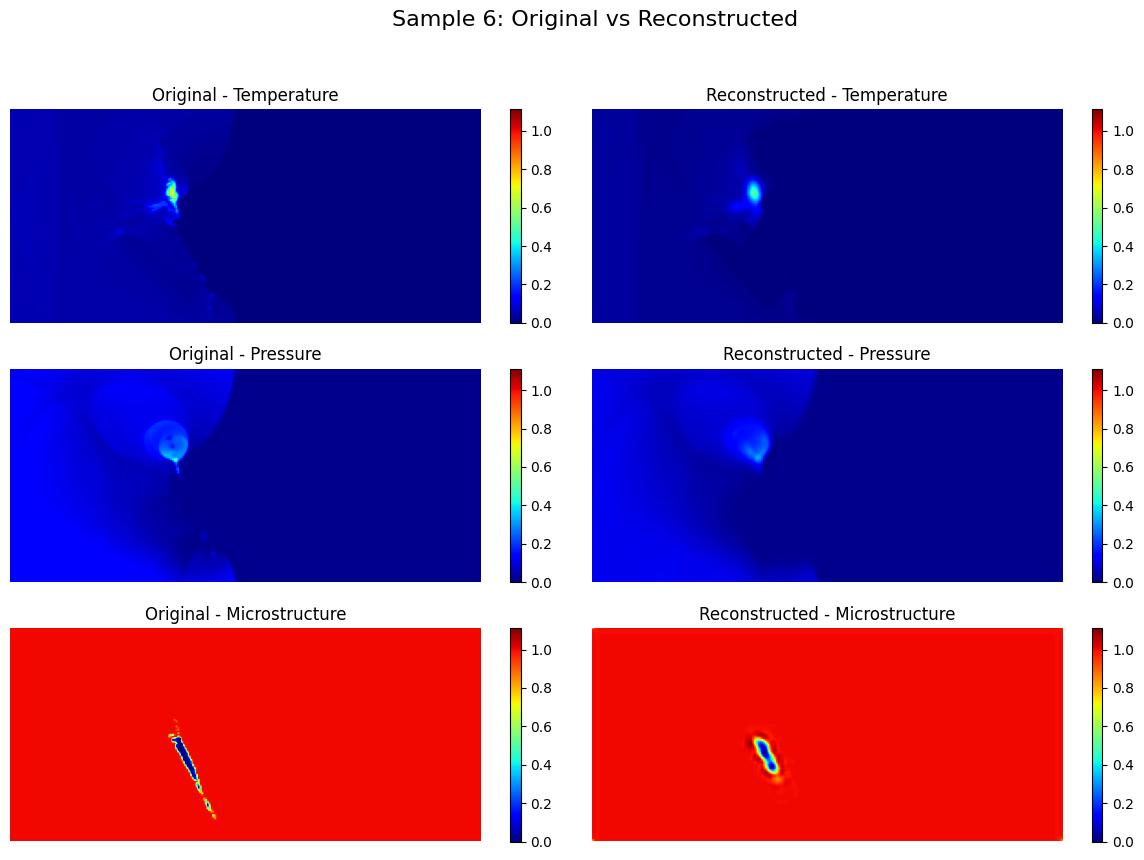

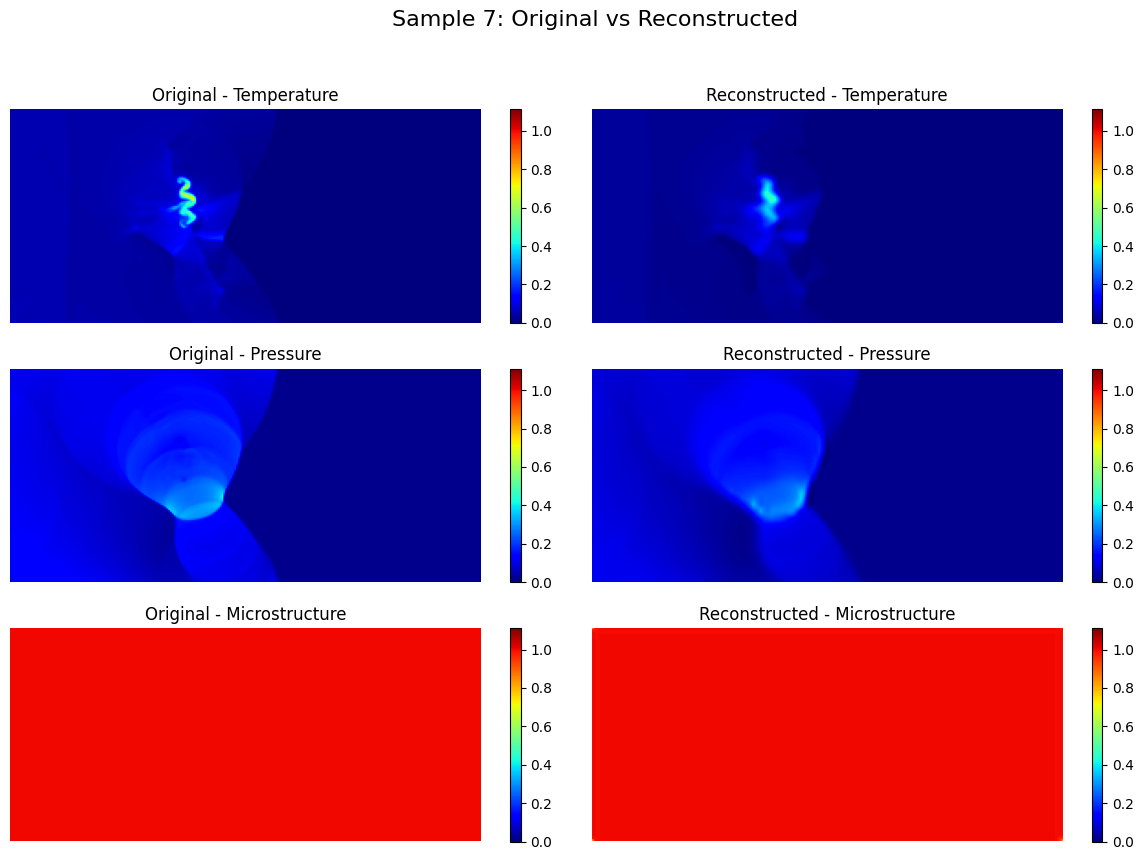

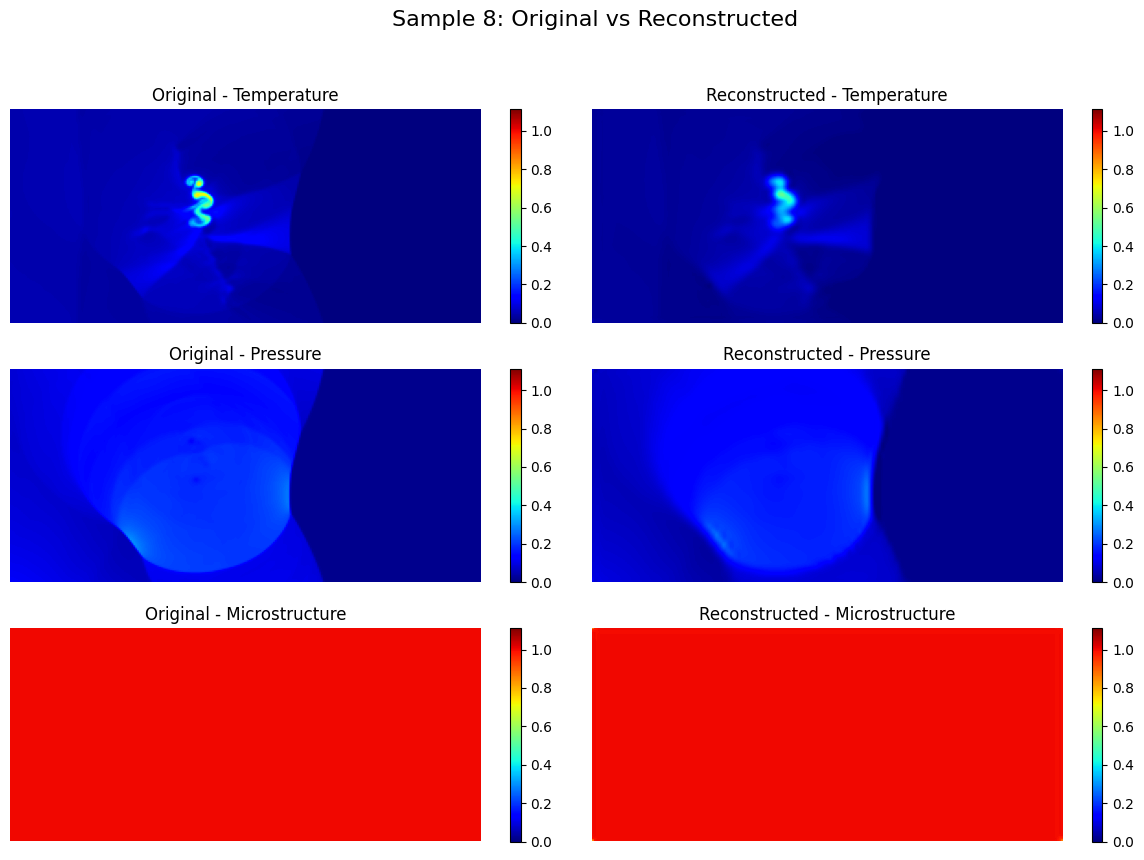

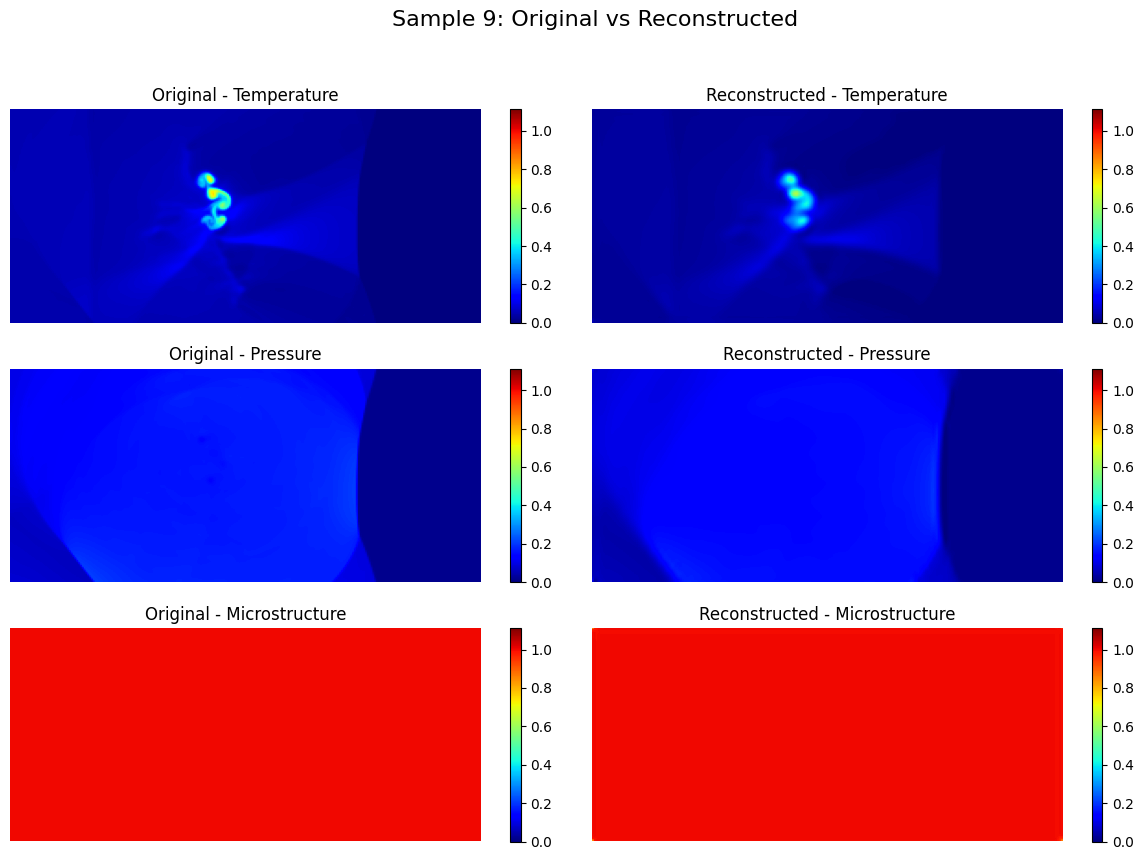

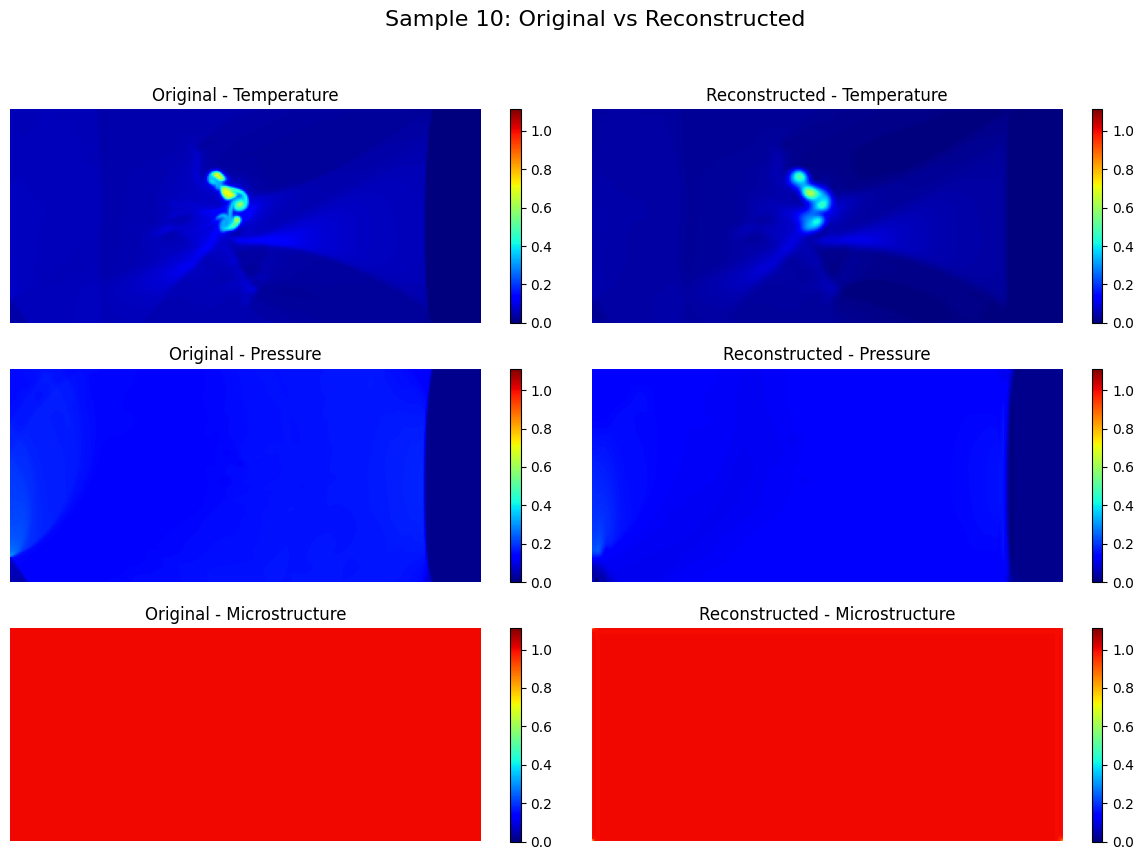

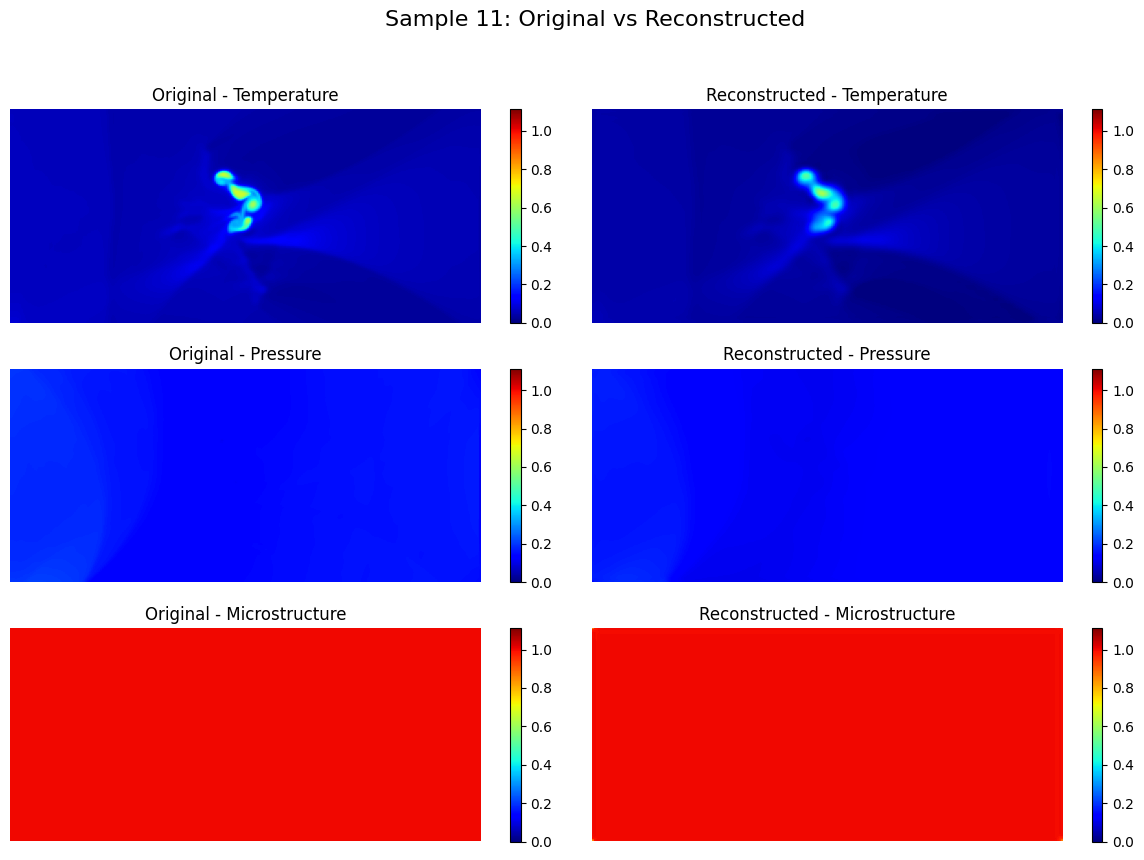

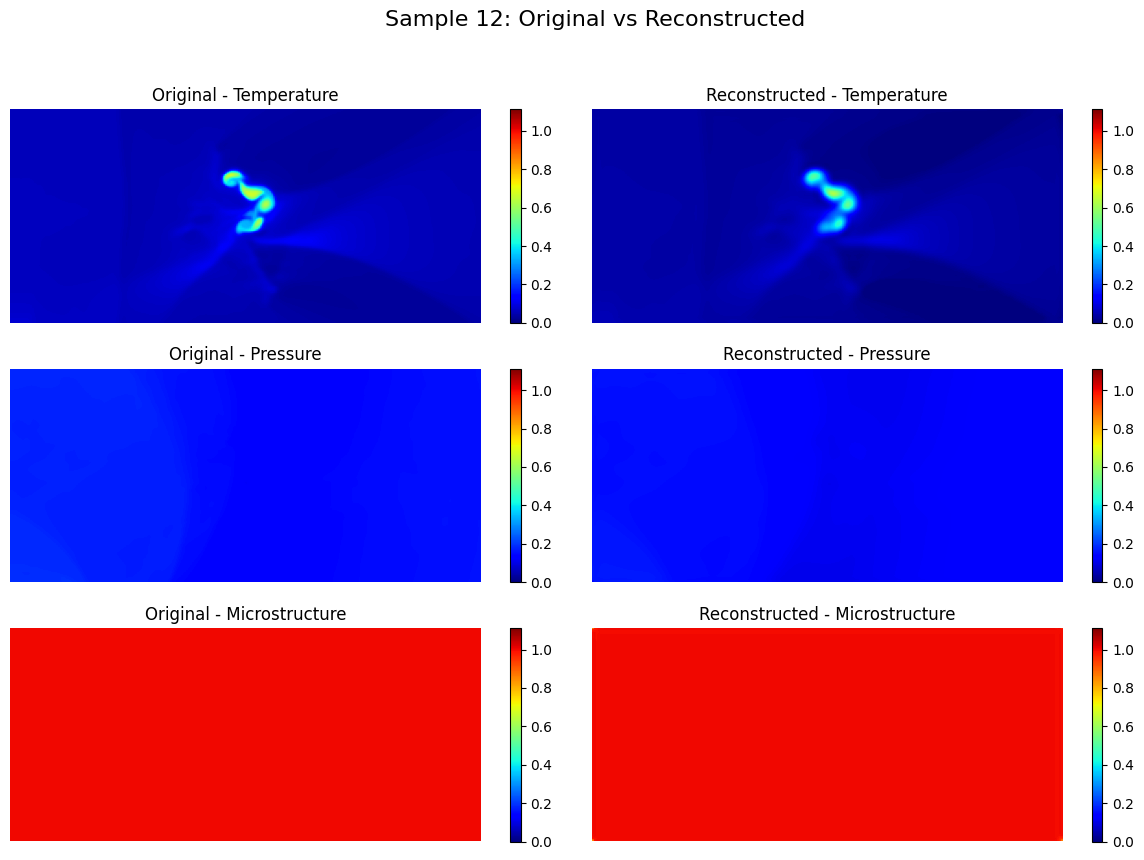

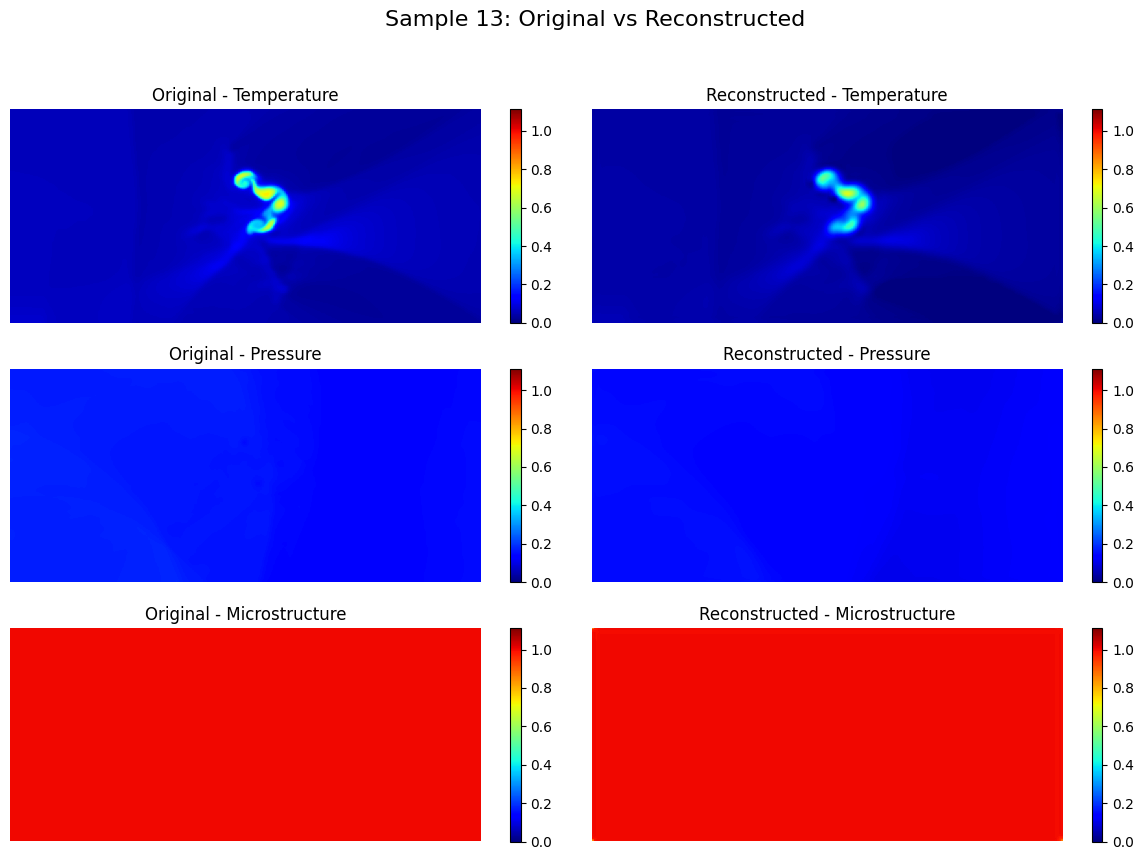

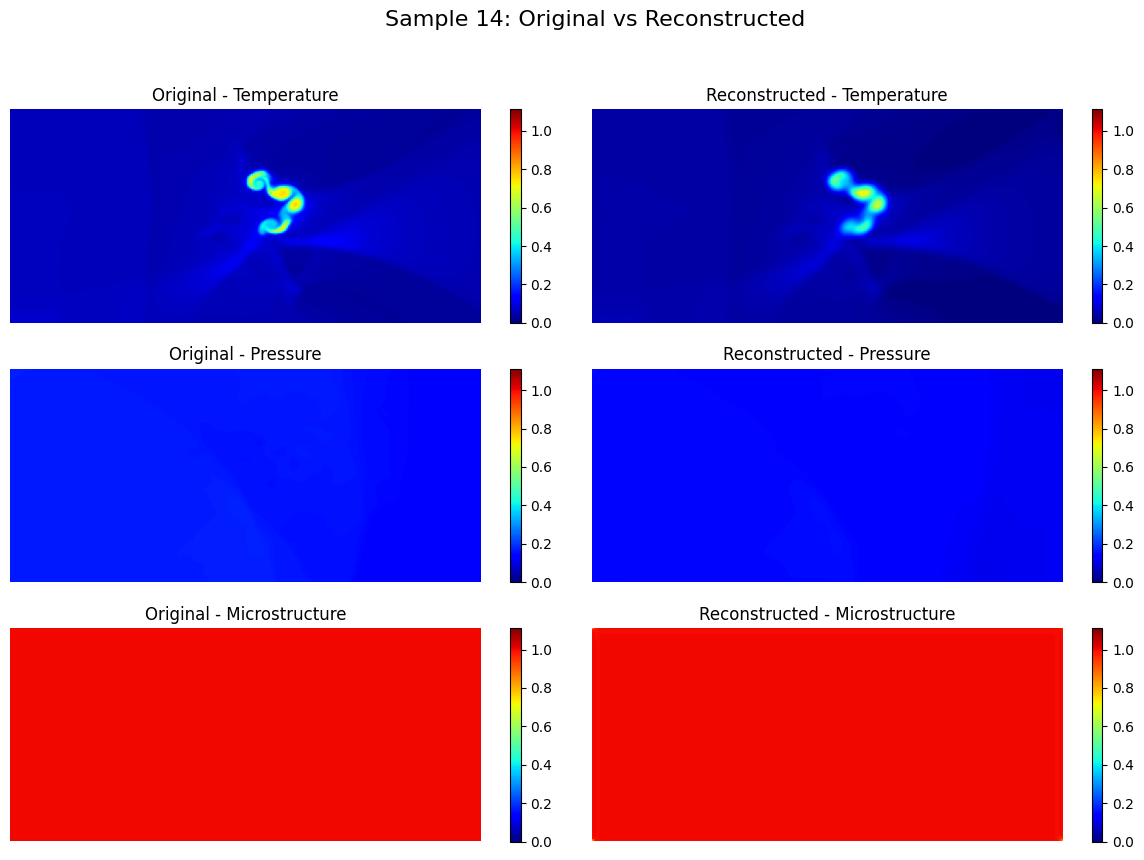

In [9]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (14ts each)
num_samples = n_ts-1  # Display up to 5 samples or fewer if dataset is smaller

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(X.min(), just_AE_reconstruction_pred.min())
global_max = max(X.max(), just_AE_reconstruction_pred.max())


# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = X[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = just_AE_reconstruction_pred[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()

### Z Hat Viz

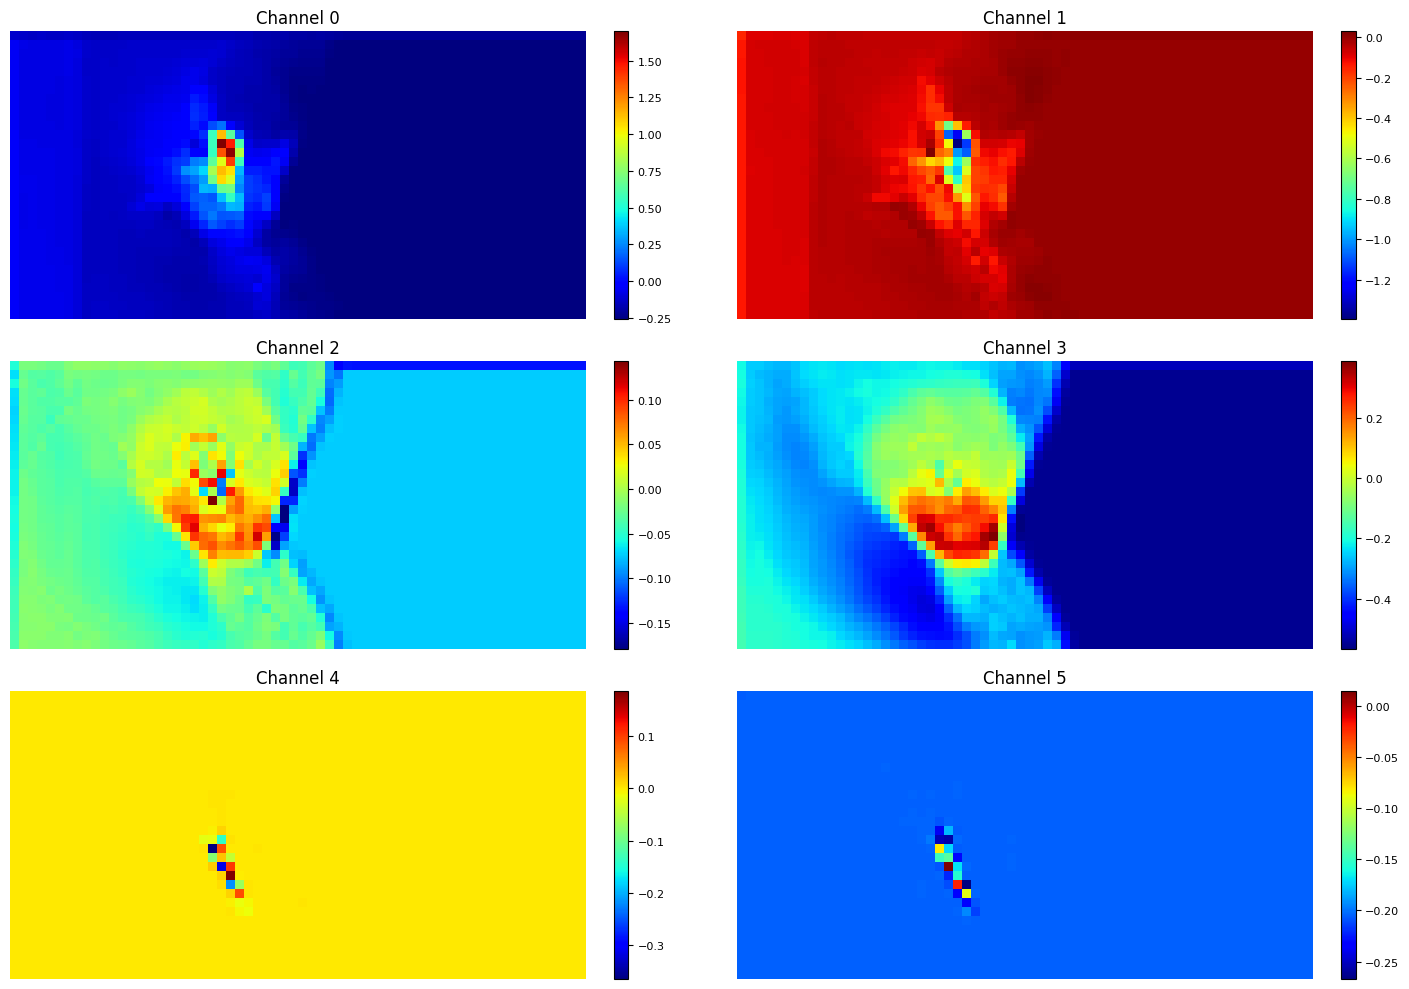

In [11]:
# select timestep to view
ts = 5
latent_dim = 2
n_latent_channels = latent_dim *3

# Extract the 16-channel image at timestep ts
images = single_ts_Zhat[ts, ...]

# Convert to CPU and numpy for visualization
images = images.cpu().detach().numpy()

# Plot all 16 channels in a 4x4 grid with colorbars
fig, axes = plt.subplots(3, latent_dim, figsize=(15, 10))

for idx, ax in enumerate(axes.flat):
    if idx < n_latent_channels:
        im = ax.imshow(images[idx], cmap="jet")
        ax.set_title(f"Channel {idx}")
        ax.axis("off")

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)  # Adjust tick label size

plt.tight_layout()
plt.show()

### Z_hat GIF

In [33]:
import imageio

file_save_name = "z_fields_rollout_train_nts_5"
frames = []

# Step 1: Compute per-channel vmin and vmax across all timesteps
all_data = single_ts_Zhat.cpu().detach().numpy()  # Shape: (timesteps, 16, H, W)
channel_vmin = all_data.min(axis=(0, 2, 3))  # Shape: (16,)
channel_vmax = all_data.max(axis=(0, 2, 3))  # Shape: (16,)

print("Per-channel vmin and vmax computed.")

# Step 2: Create GIF frames
for ts in range(n_ts - 1):
    images = all_data[ts]  # Shape: (16, H, W)

    fig, axes = plt.subplots(3, latent_dim, figsize=(15, 10))

    for idx, ax in enumerate(axes.flat):
        if idx < n_latent_channels:
            im = ax.imshow(
                images[idx],
                cmap="jet",
                vmin=channel_vmin[idx],
                vmax=channel_vmax[idx]
            )
            ax.set_title(f"Channel {idx}")
            ax.axis("off")

            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()

    # Save frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frame = frame[..., :3]  # Remove alpha channel
    frames.append(frame)

    plt.close(fig)

# Step 3: Save GIF with infinite loop and longer duration
imageio.mimsave(
    f'{file_save_name}.gif',
    frames,
    duration=500,
    loop=0
)

print(f"GIF saved as '{file_save_name}.gif'")

Per-channel vmin and vmax computed.
GIF saved as 'z_fields_rollout_train_nts_5.gif'


### AE + Dynamics Evaluation (SNAPSHOT SINGLE TS)

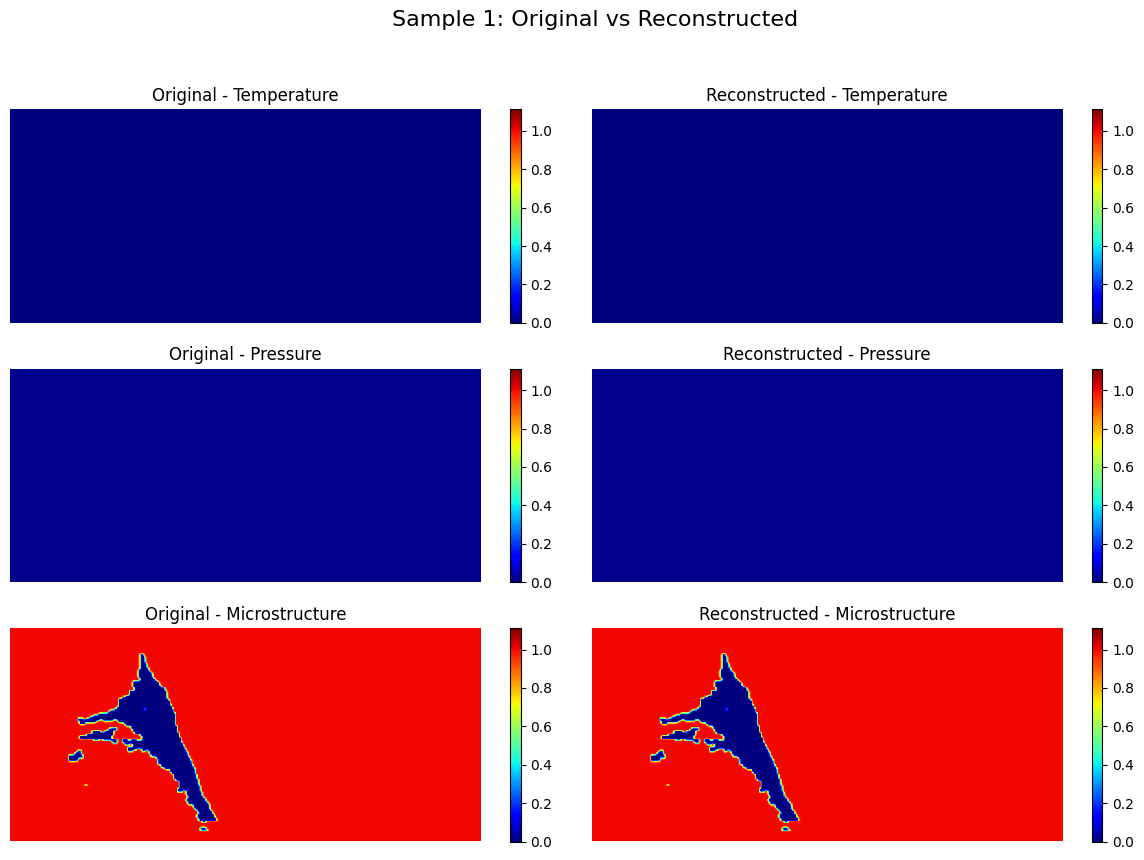

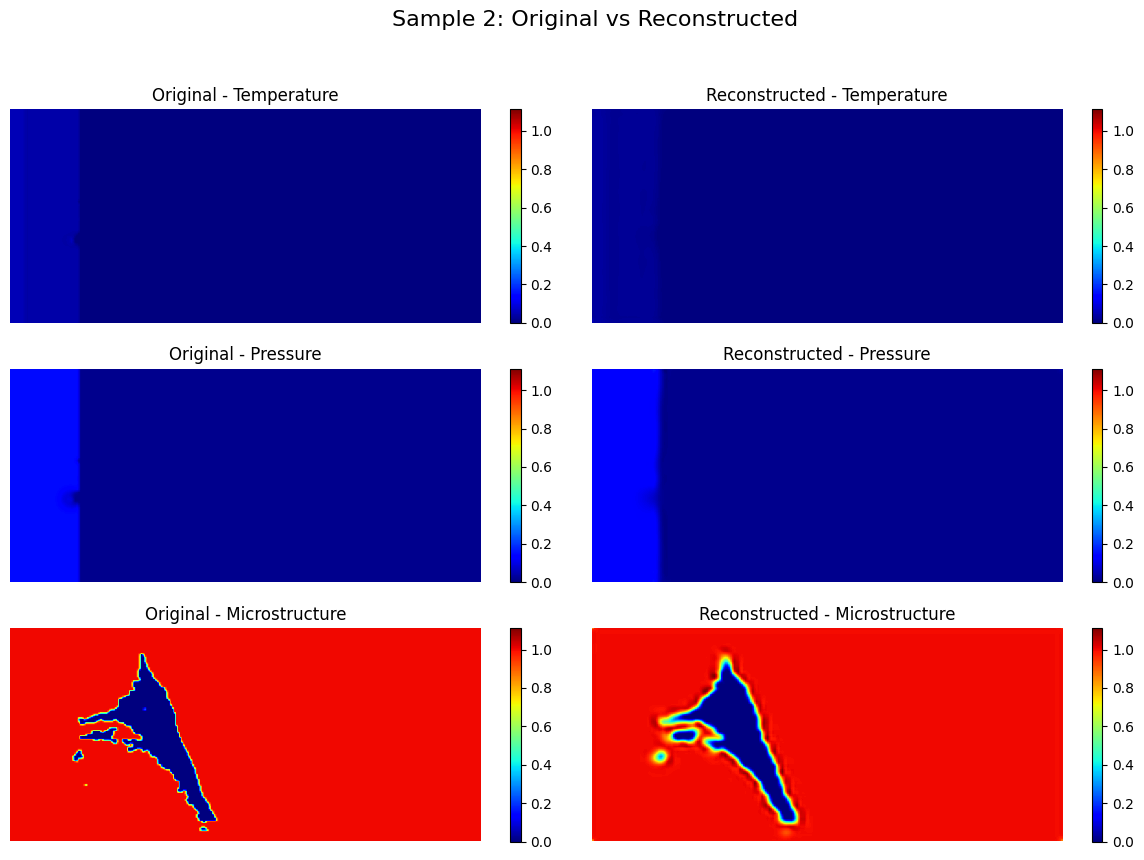

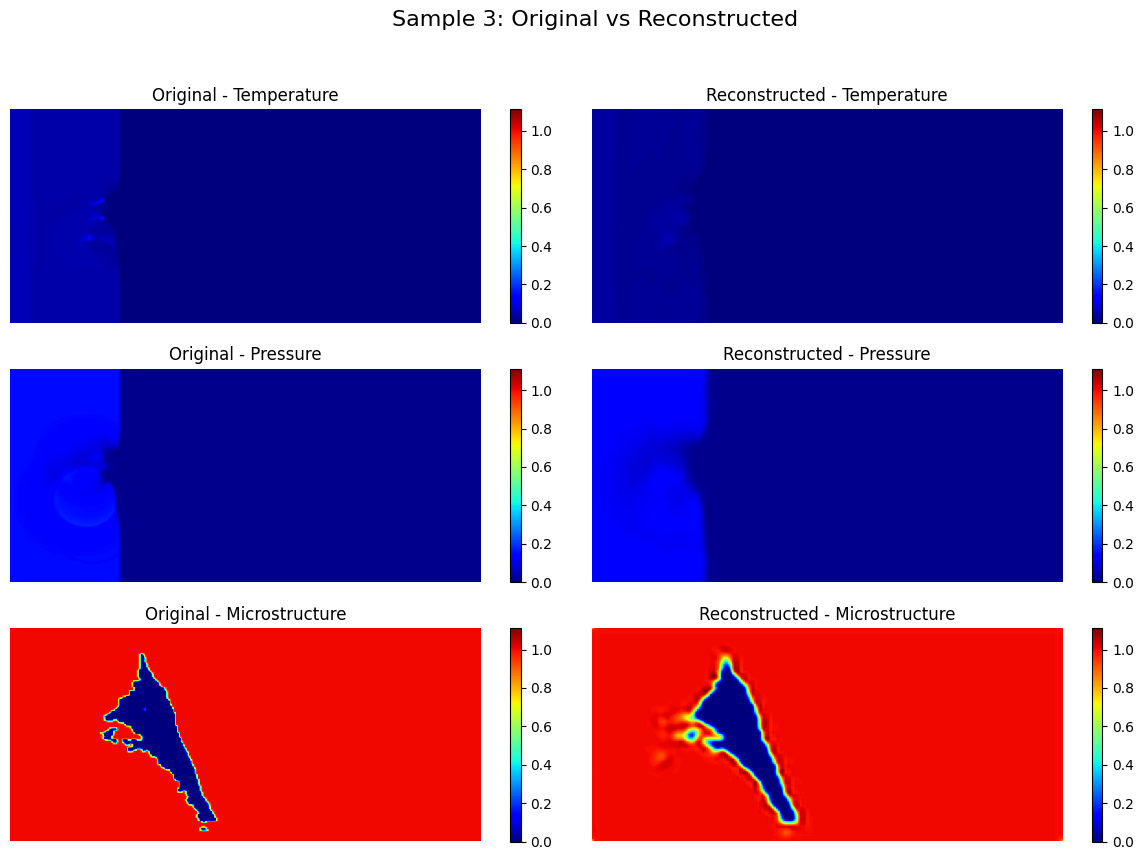

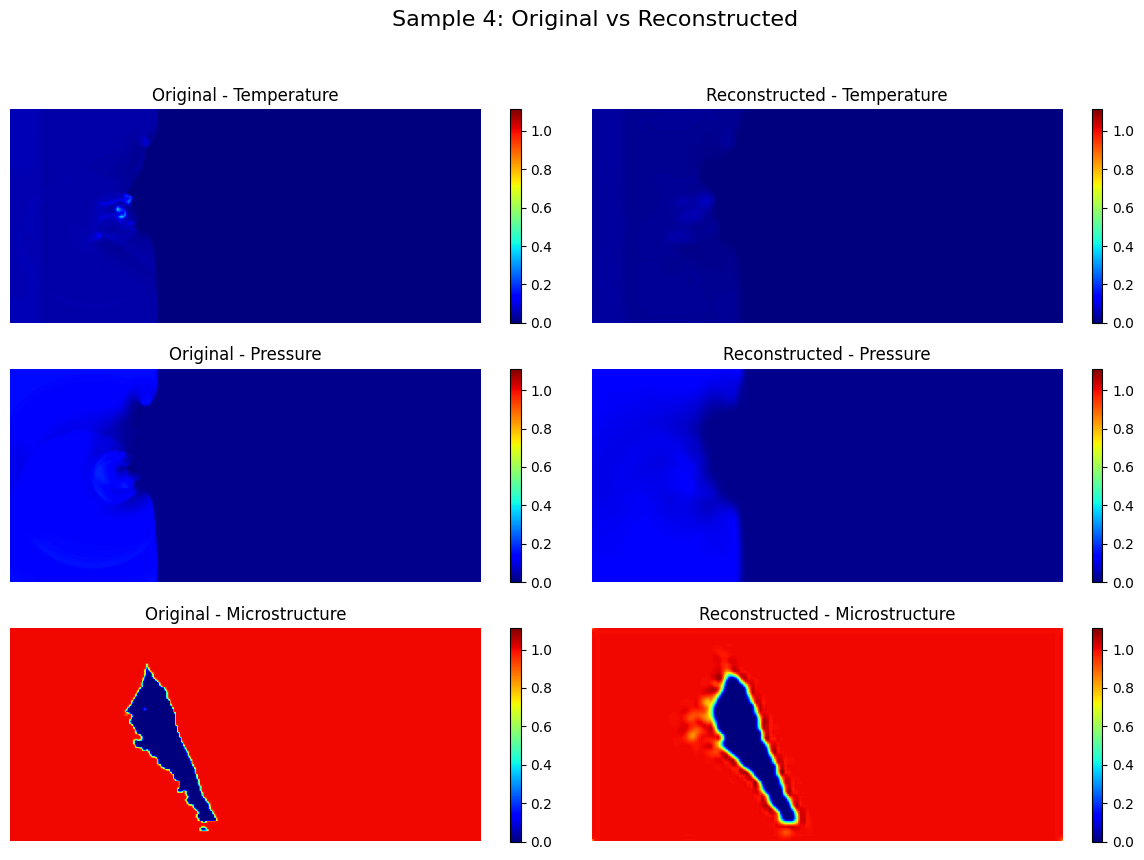

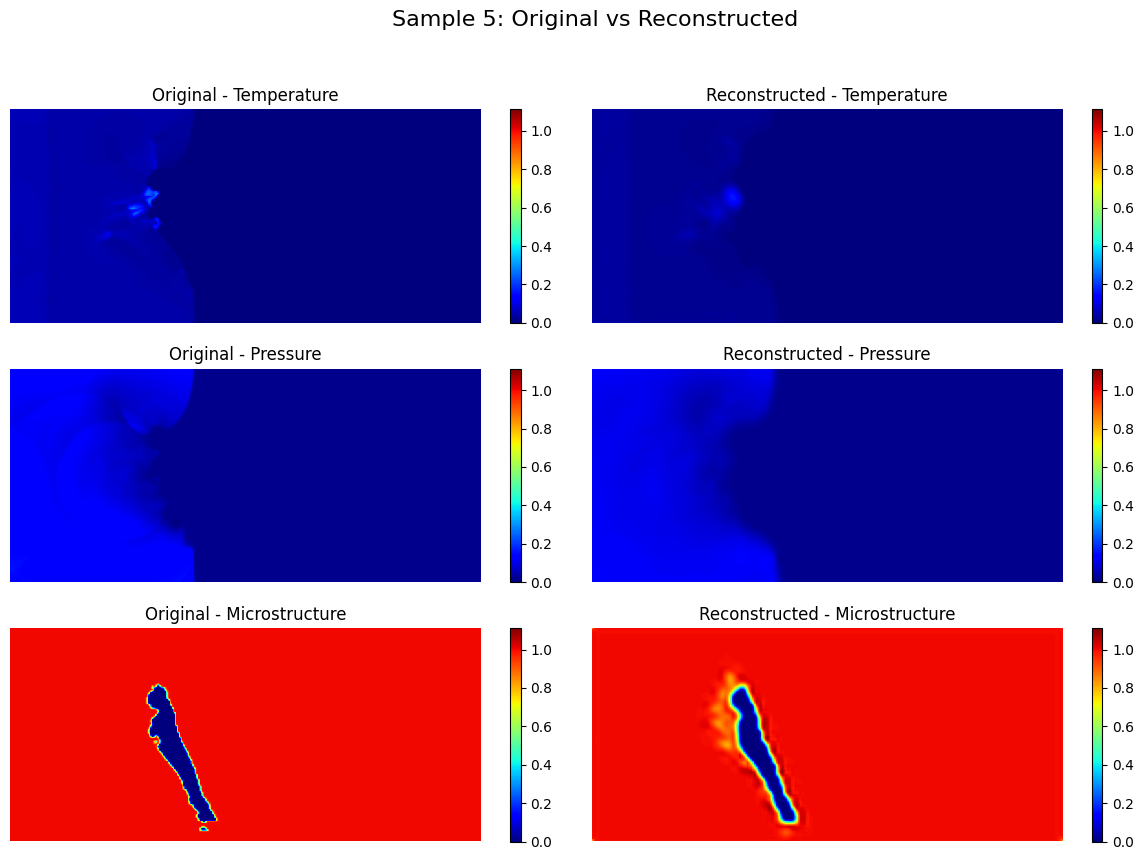

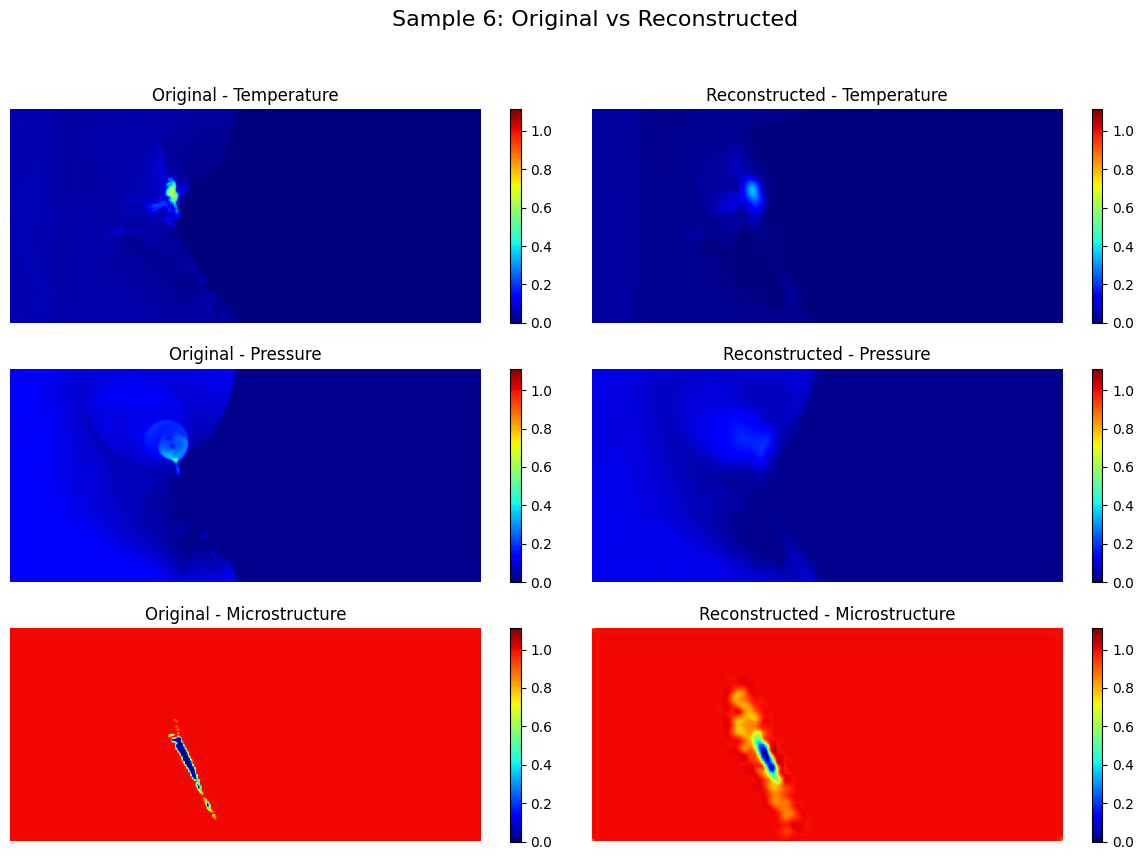

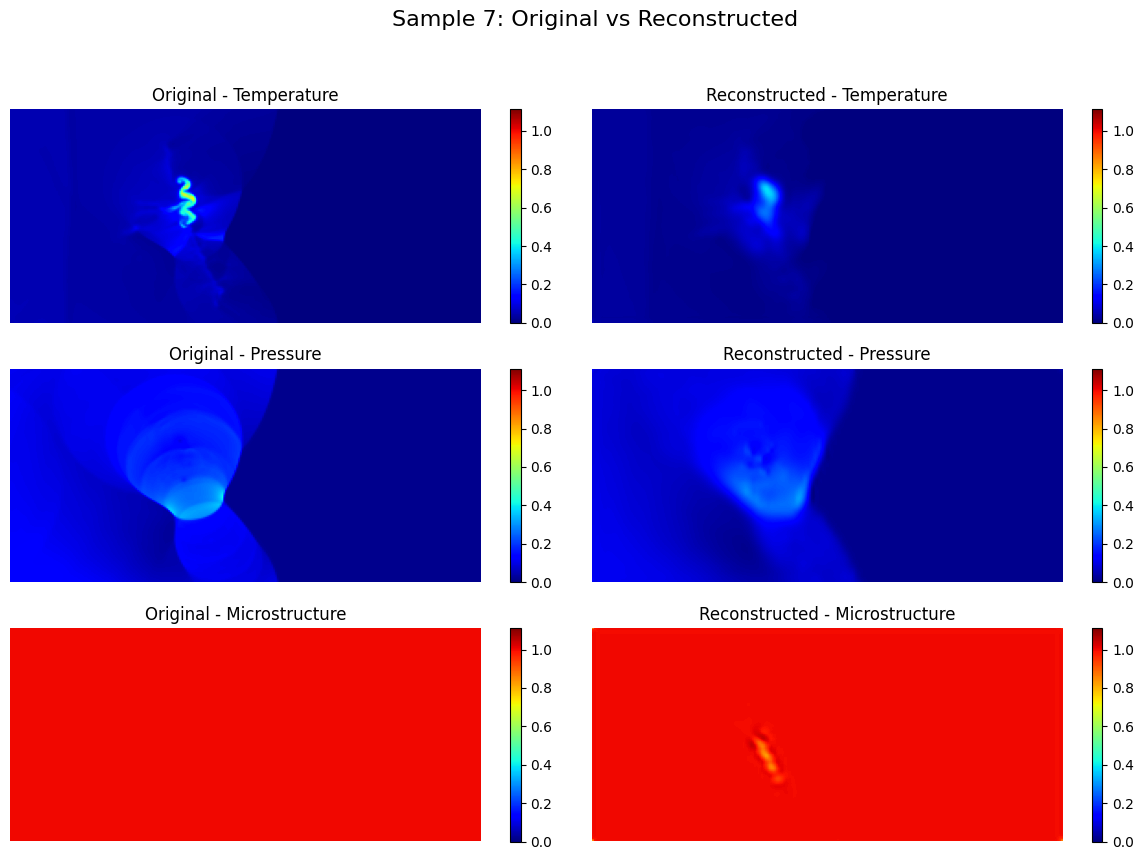

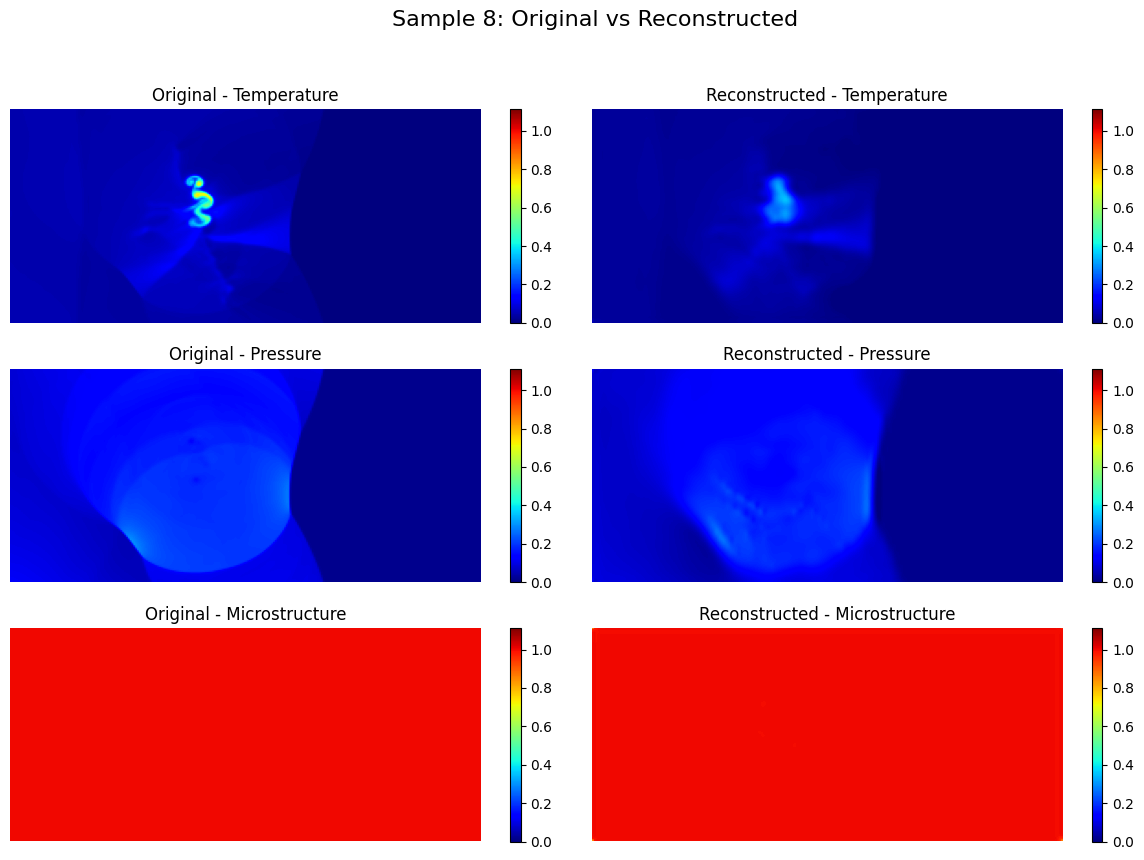

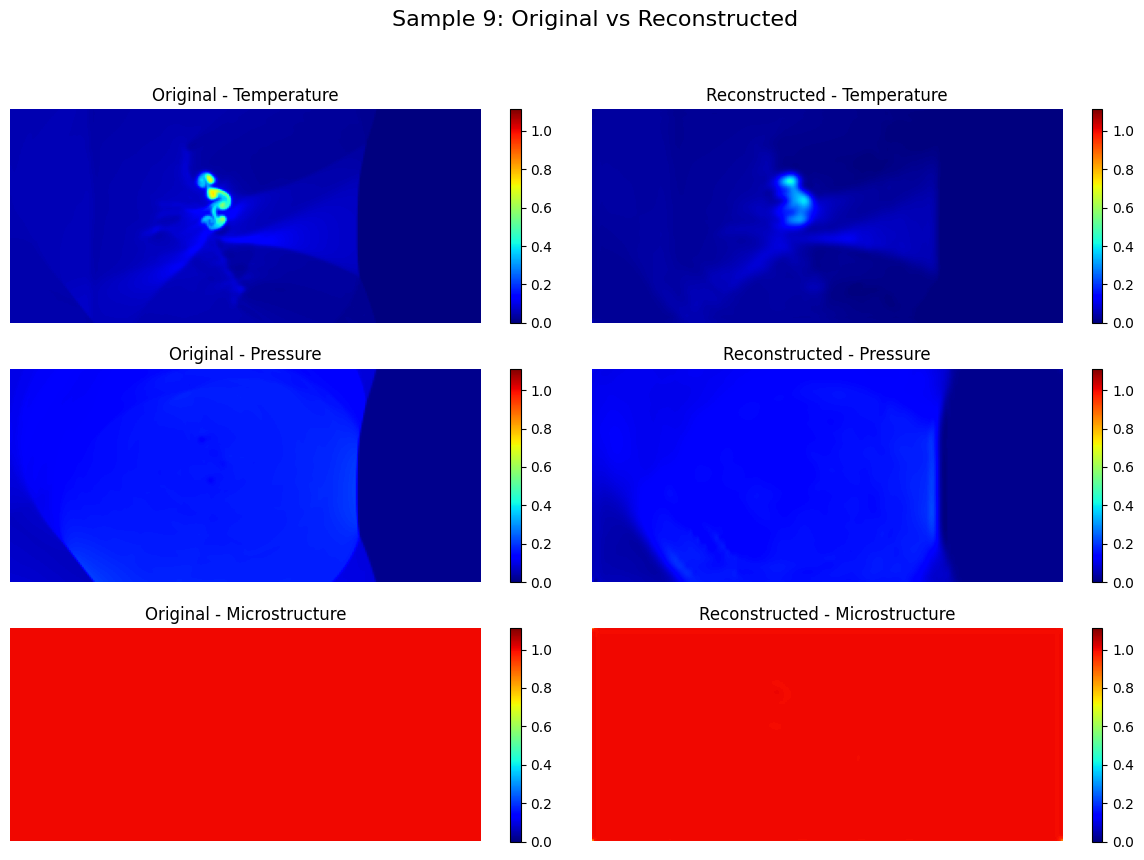

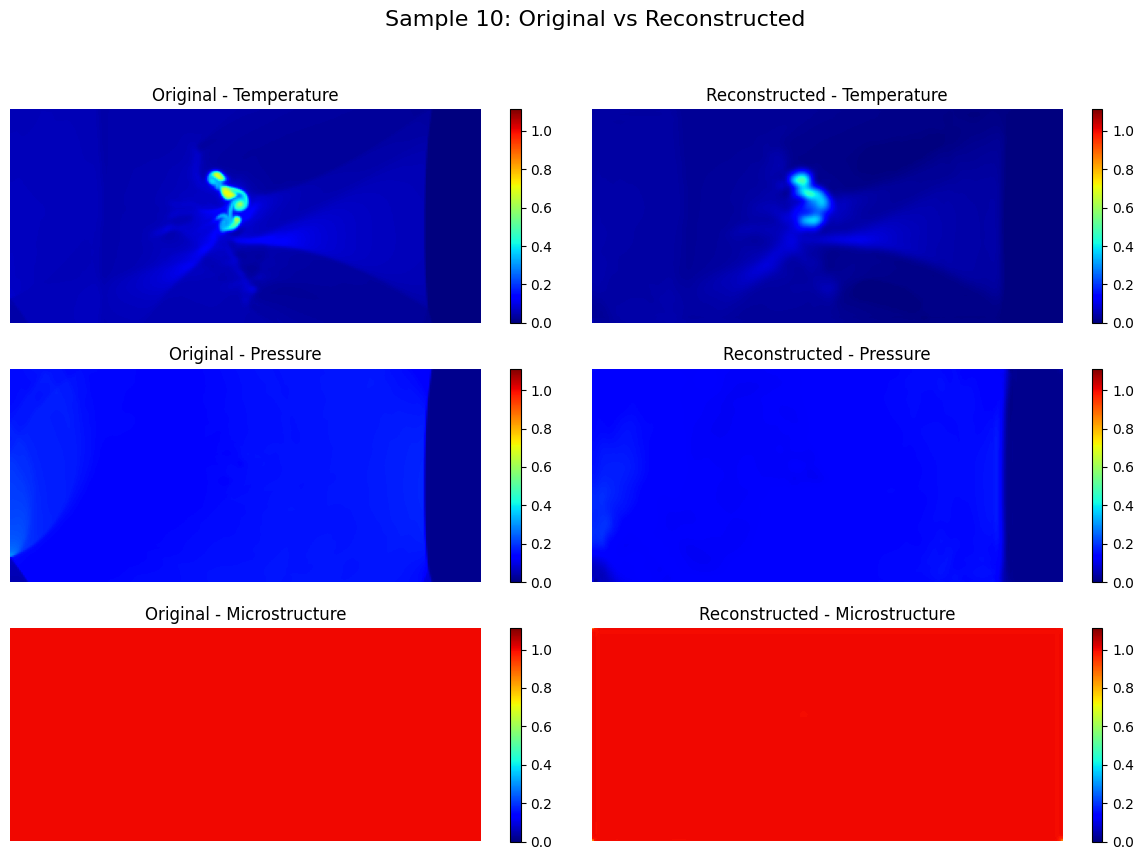

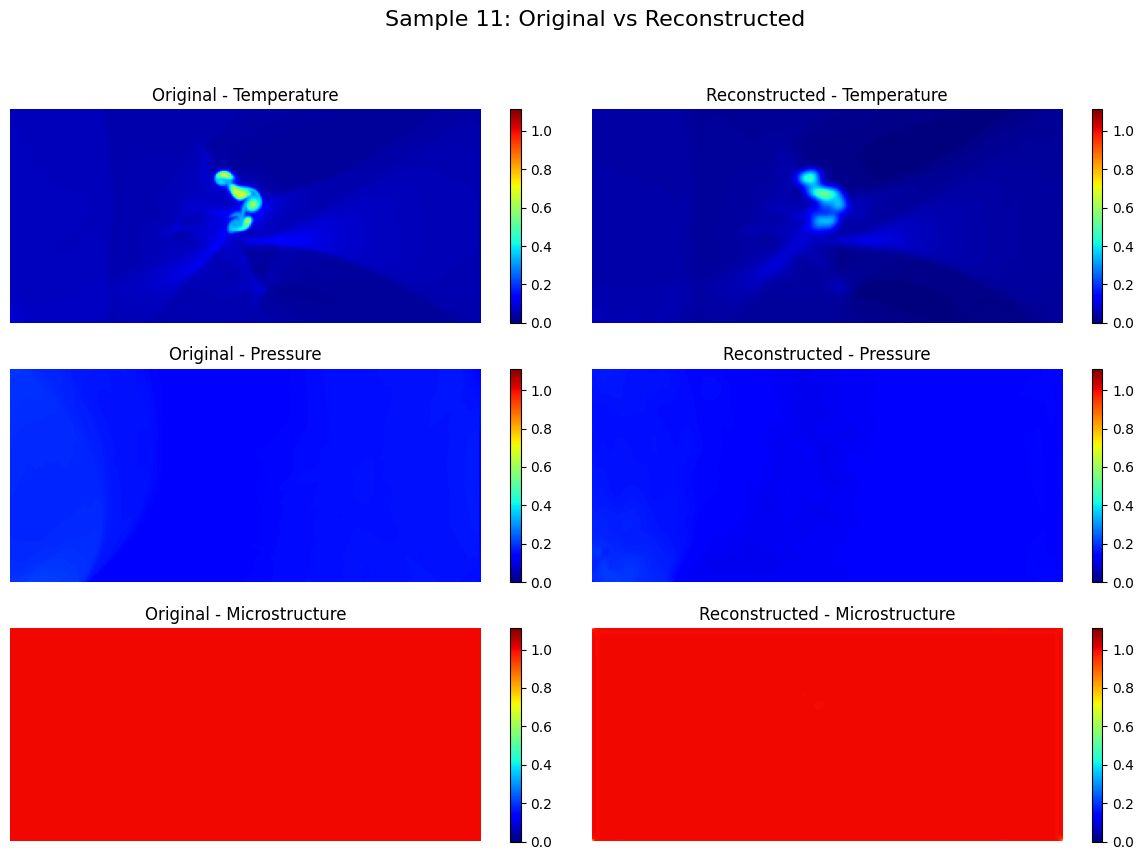

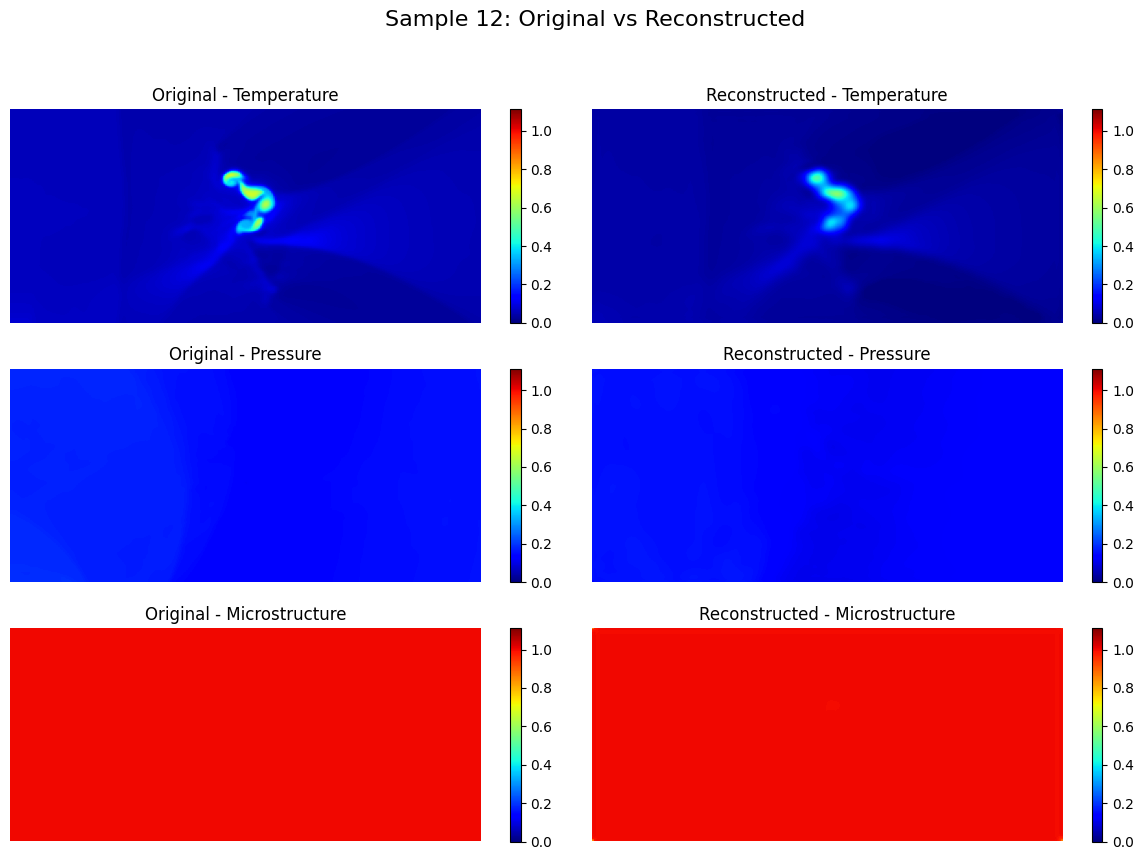

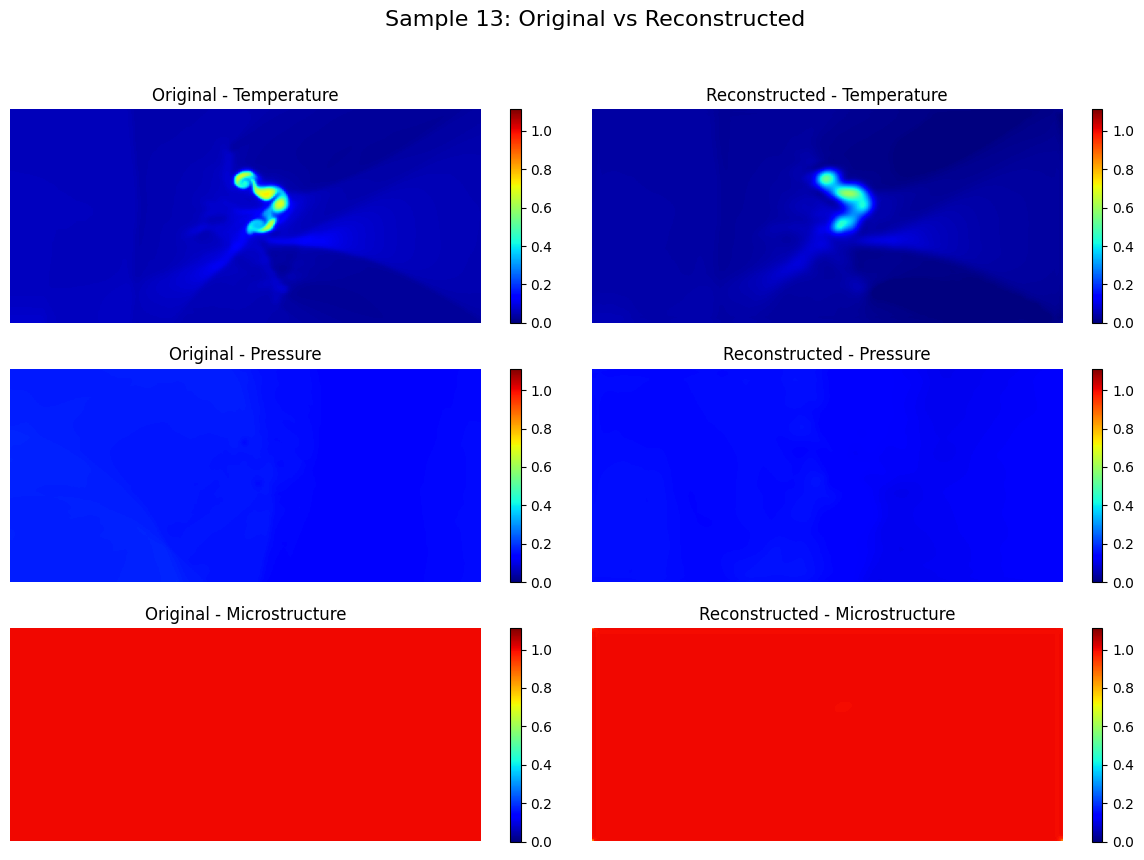

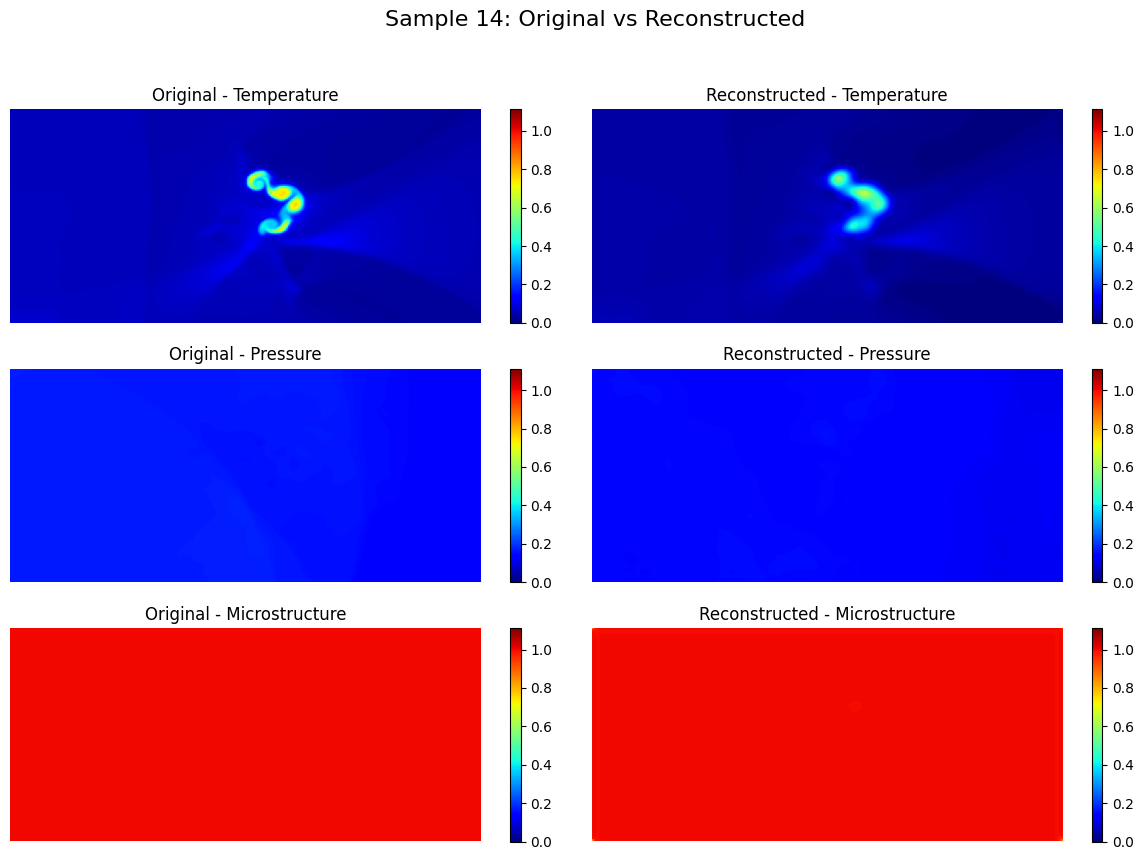

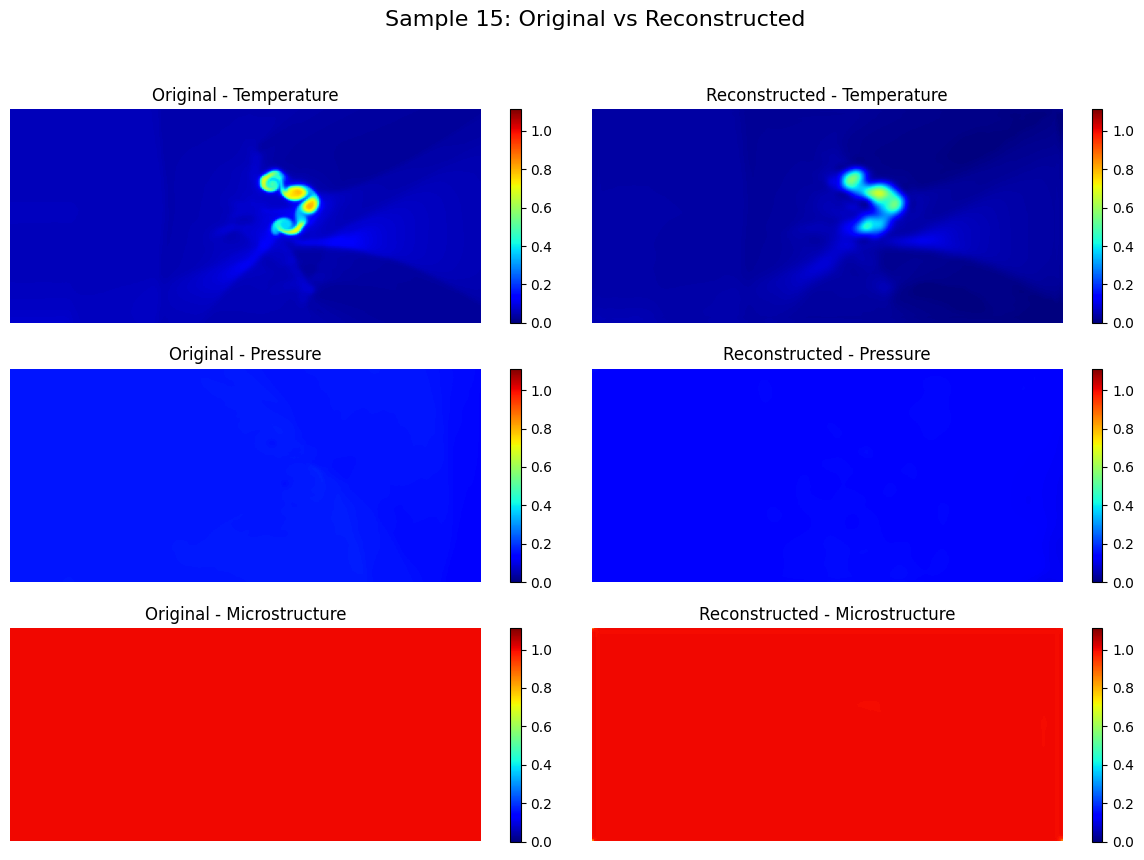

In [10]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
num_samples = n_ts
# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(X.min(), single_ts_full_reconstruction_pred.min())
global_max = max(X.max(), single_ts_full_reconstruction_pred.max())

# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = X[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = single_ts_full_reconstruction_pred[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()

### GIF

In [11]:
from PIL import Image

file_name = "single_ts_rollout_train_nts_5_FROZEN_3enc_3dec_vertflip_ReLU_normal_conv_ReLU_out_layers_1_2_latent_6_NONOISE_LRplateau_factor8_pat10_1000"
plot_name = "Single ts Prediction, 1 Encoder 1 Decoder, no purple loss Layers 3 8, Latent Dim 16, 2 Test Samples, 3000 Epochs"

# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
# num_samples = min(28, single_ts_full_reconstruction_GT.shape[0])  # Display up to 30 samples or fewer if dataset is smaller
num_samples = n_ts

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(X.min(), single_ts_full_reconstruction_pred.min())
global_max = max(X.max(), single_ts_full_reconstruction_pred.max())

frames = []  # List to store frames for GIF

# Iterate over the selected samples (each sample represents a time step)
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(2, 3, figsize=(6, 4), dpi=150, constrained_layout=True)  # Reduced figsize and dpi for smaller GIF
    fig.suptitle(plot_name, fontsize=12)  # Reduced font size for title
    
    for channel_idx, channel_name in enumerate(channel_names):
        original_channel = X[sample_idx, channel_idx, :, :].numpy()
        reconstructed_channel = single_ts_full_reconstruction_pred[sample_idx, channel_idx, :, :].numpy()
        
        # Plot original
        ax = axes[0, channel_idx]
        ax.imshow(original_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (GT)", fontsize=10)  # Smaller title font size
        ax.axis("off")
        
        # Plot reconstructed
        ax = axes[1, channel_idx]
        ax.imshow(reconstructed_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (Pred)", fontsize=10)  # Smaller title font size
        ax.axis("off")
    
    # Convert the figure to a PIL Image and append to frames
    fig.canvas.draw()  # Draw the figure onto the canvas
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Reshape to image dimensions
    frames.append(Image.fromarray(img))

    plt.close(fig)

# Check if frames are created successfully
if len(frames) == 0:
    print("Error: No frames generated!")
else:
    # Save frames as GIF
    gif_path = file_name + ".gif"
    try:
        frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)
        print(f"GIF saved to {gif_path}")
    except Exception as e:
        print(f"Error saving GIF: {e}")


/tmp/ipykernel_562699/2490786714.py:42: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved to single_ts_rollout_train_nts_5_FROZEN_3enc_3dec_vertflip_ReLU_normal_conv_ReLU_out_layers_1_2_latent_6_NONOISE_LRplateau_factor8_pat10_1000.gif


# Latent Rollout Preds

In [12]:
n_channels = 3
n_ts = 15

GT = []
pred_latent = []
pred = []

with torch.no_grad():
    z, decoded = model_init(ic.unsqueeze(0).to(device), n_ts=n_ts, mode='pred')

z = z.squeeze(1).cpu()  # squeeze is remenant of needing to stack for rollout training
decoded = decoded.squeeze(1).cpu()

In [45]:
z.shape, decoded.shape

(torch.Size([15, 6, 32, 64]), torch.Size([15, 3, 128, 256]))

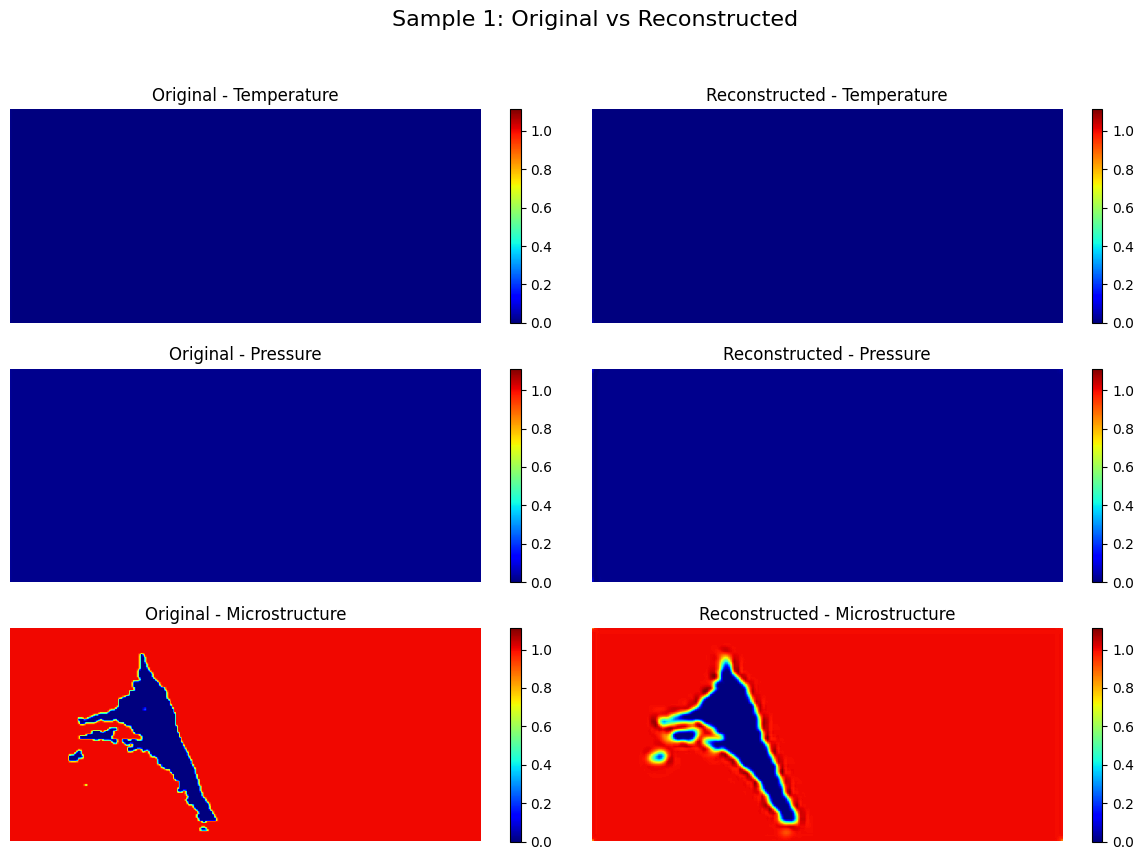

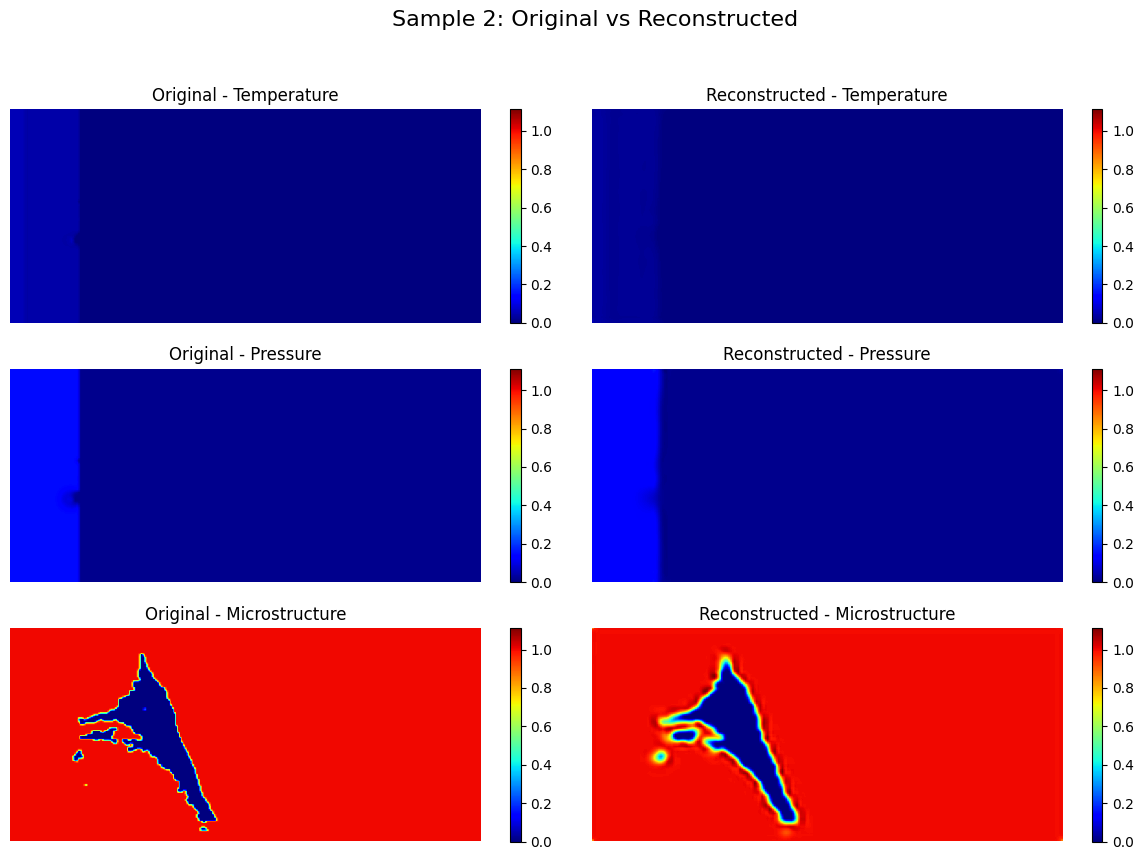

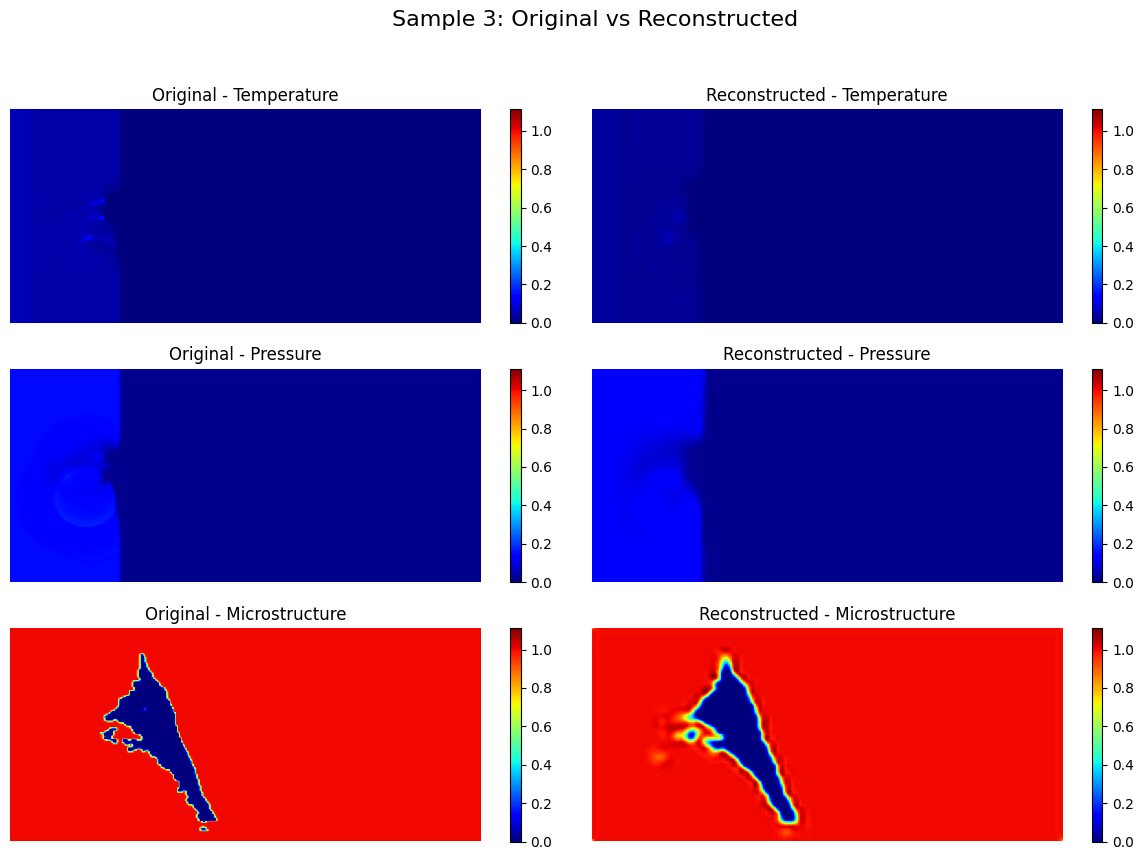

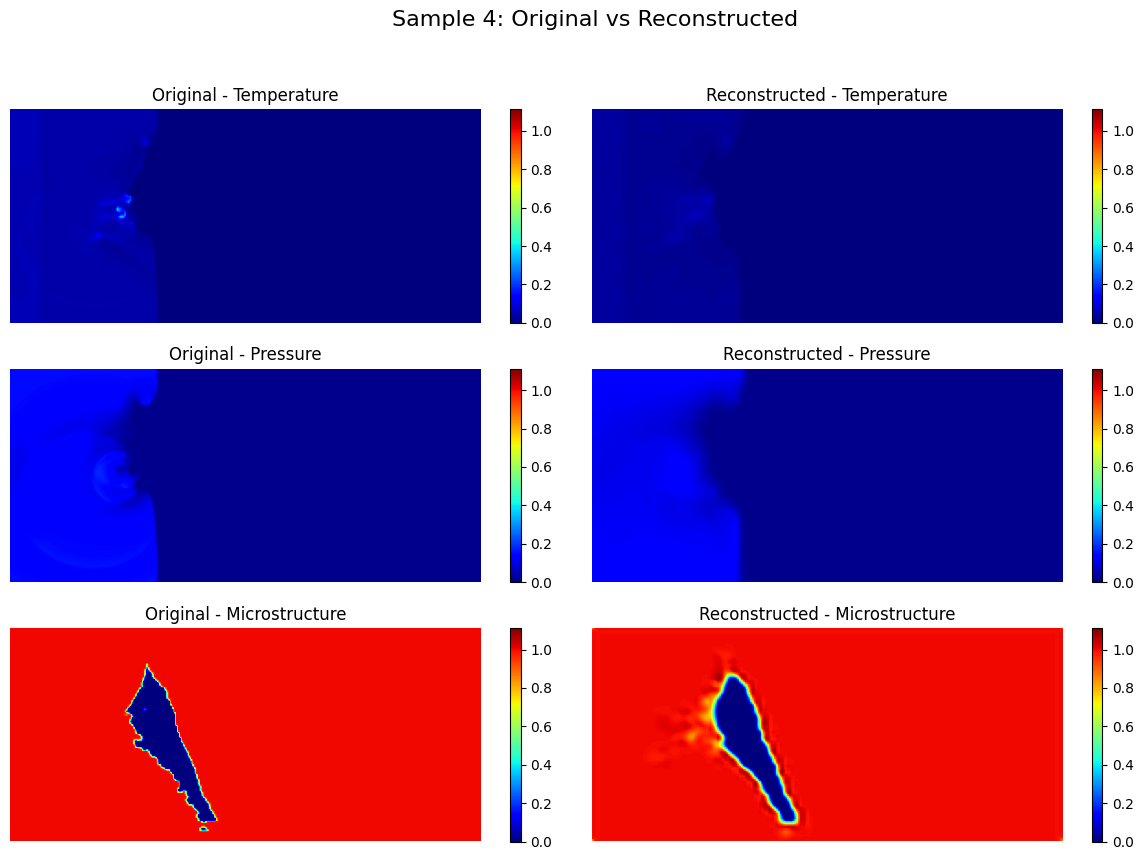

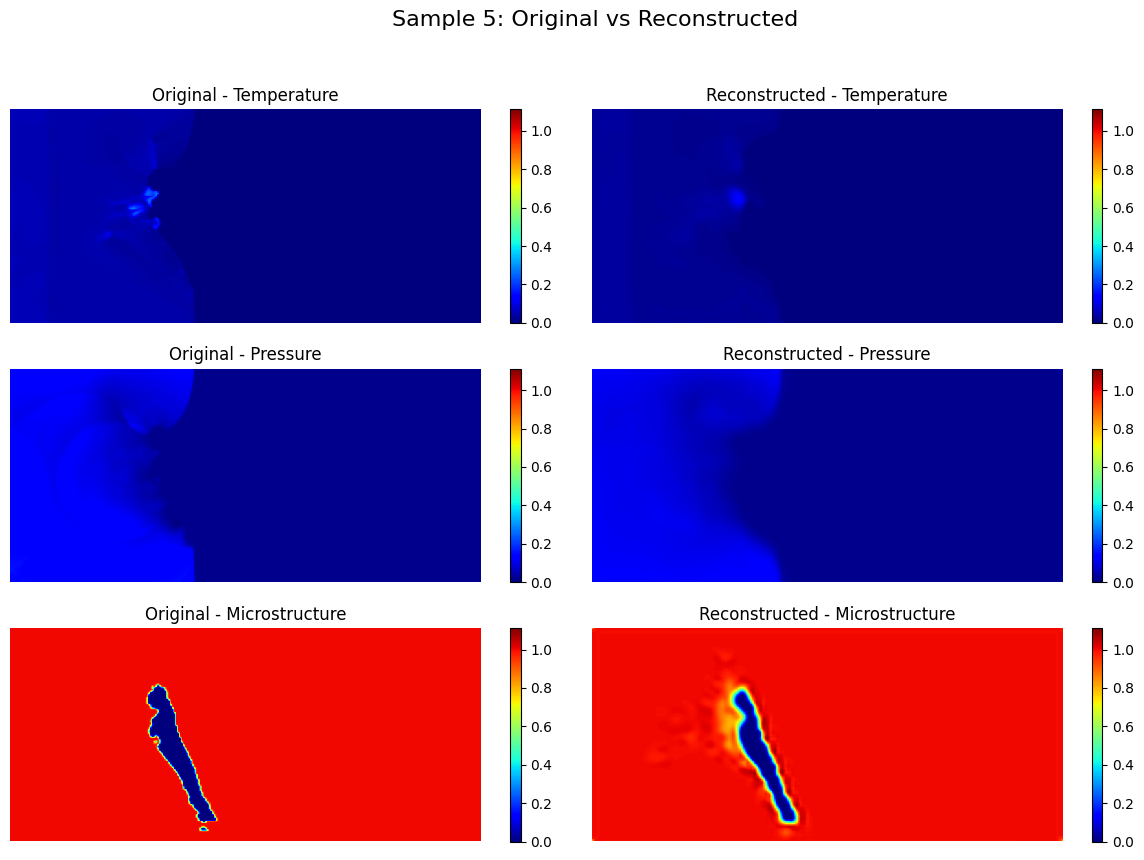

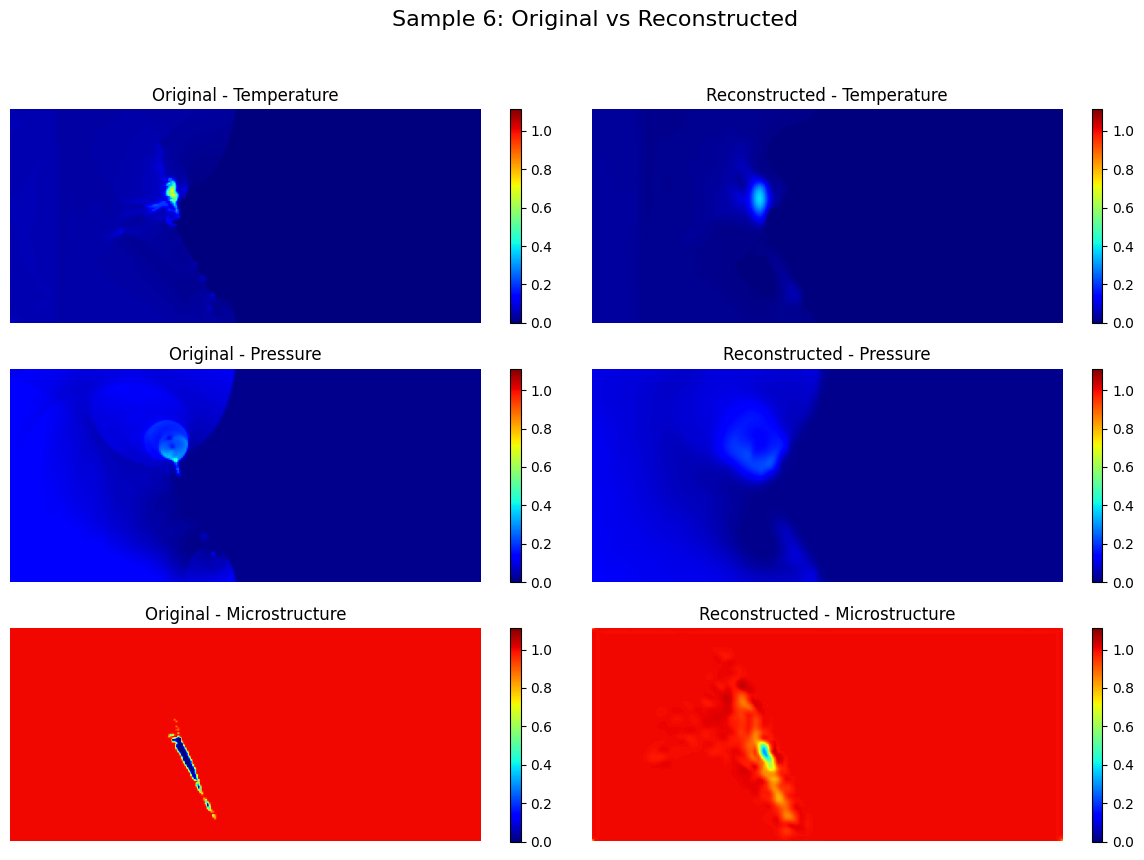

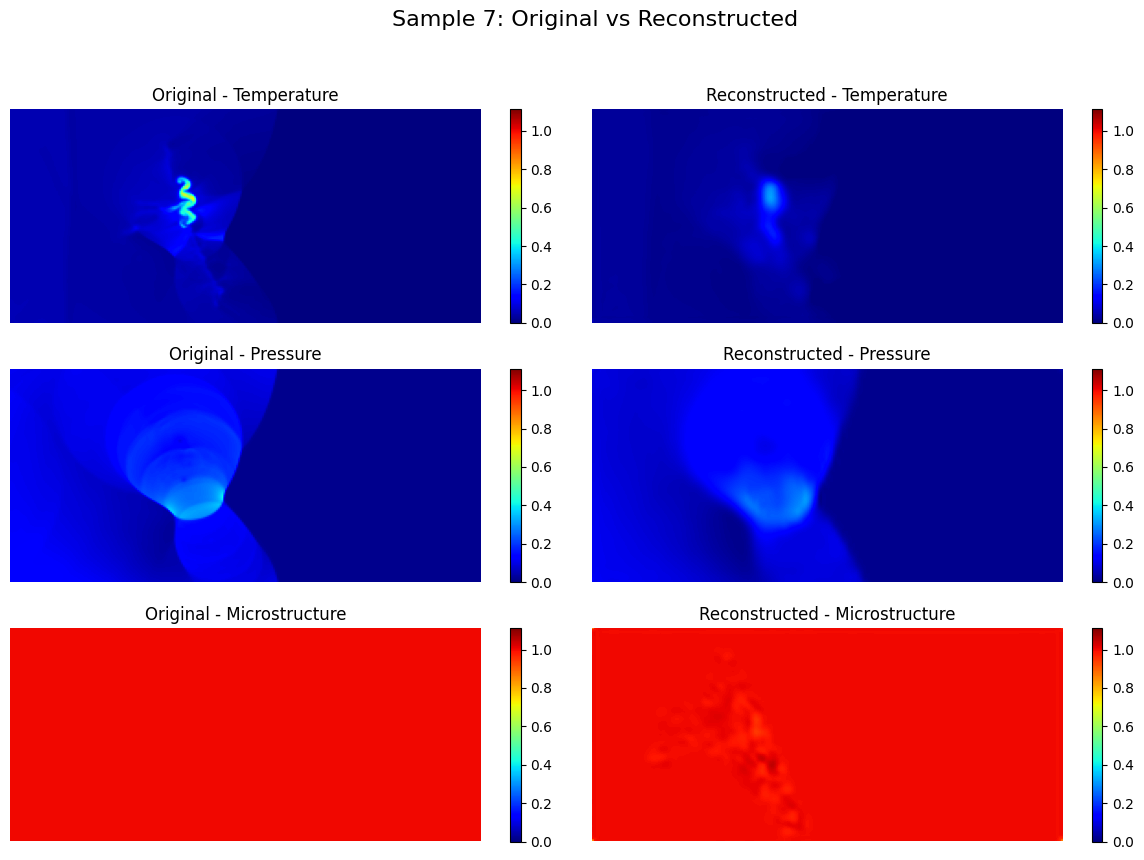

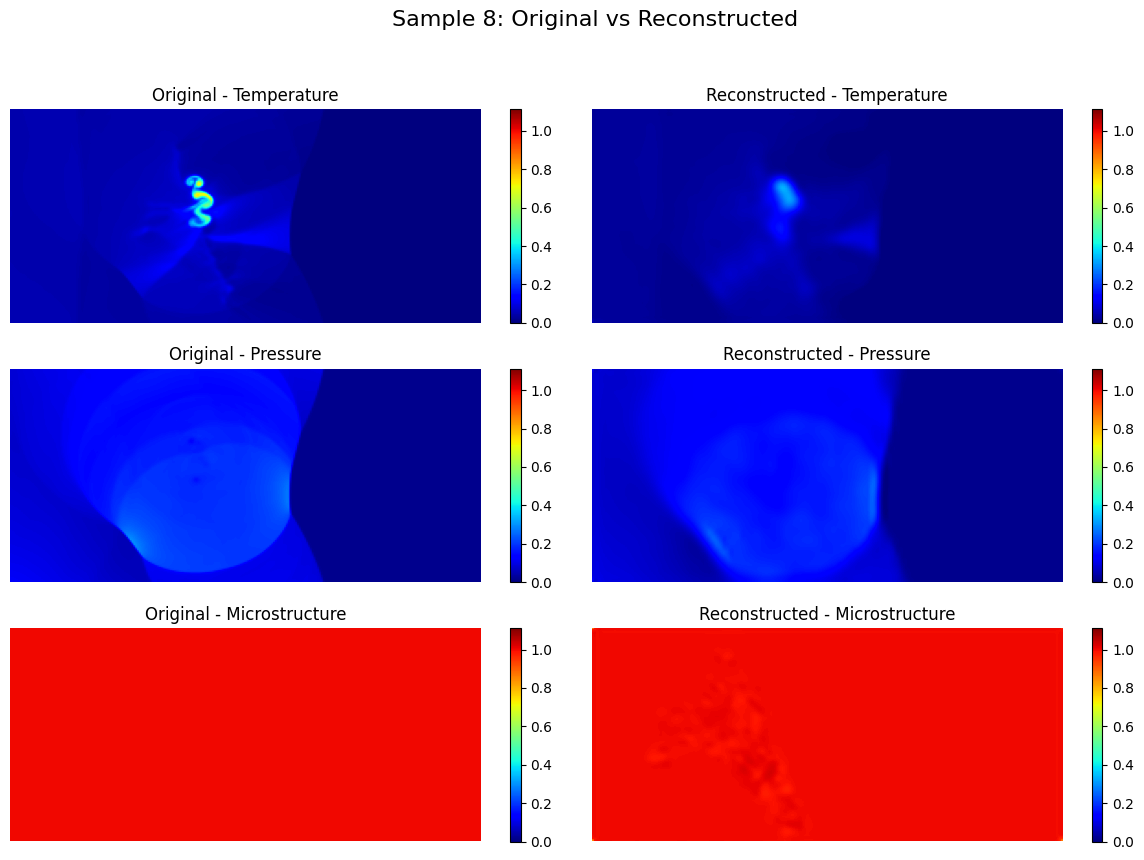

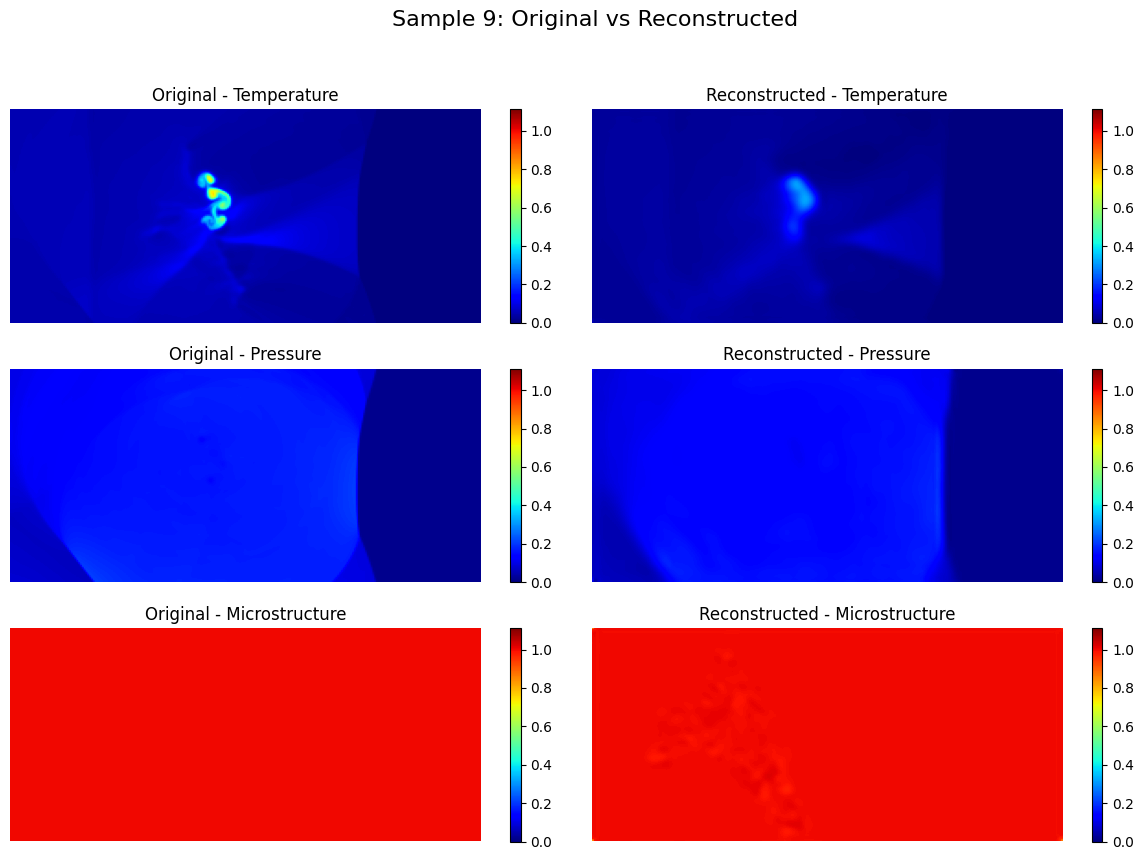

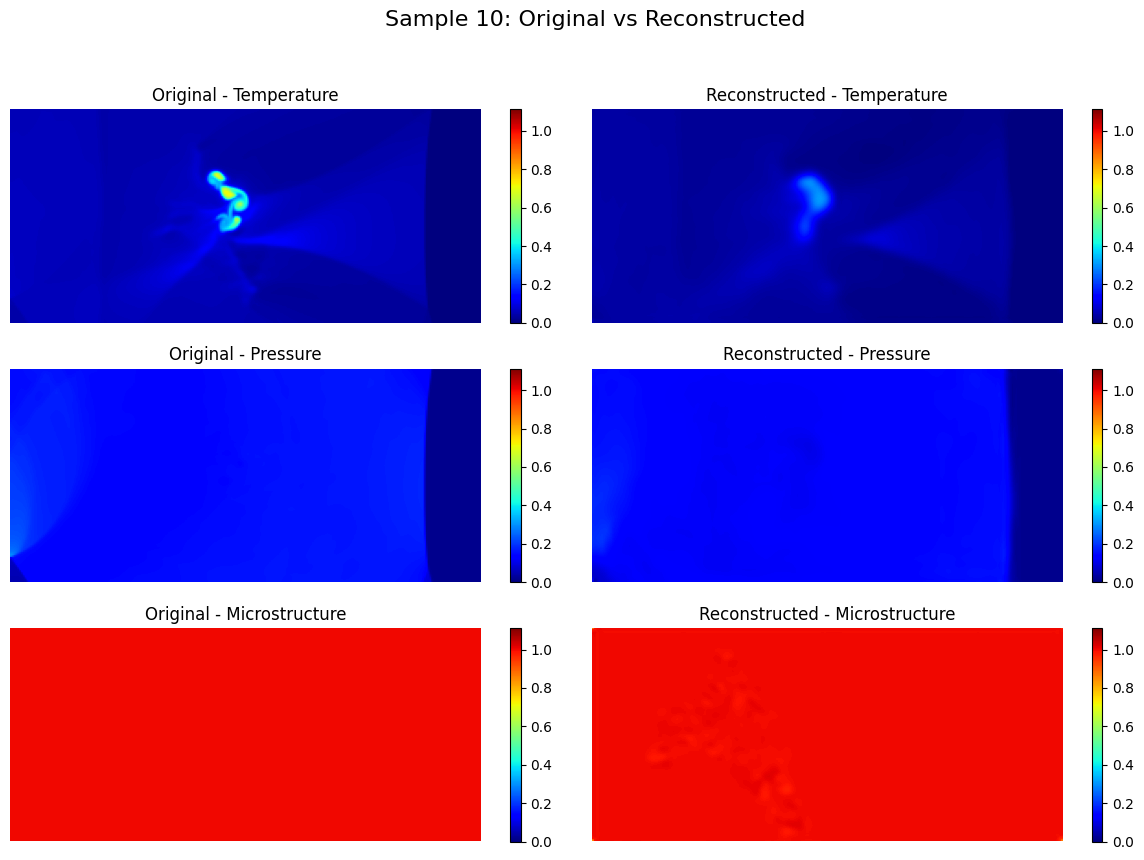

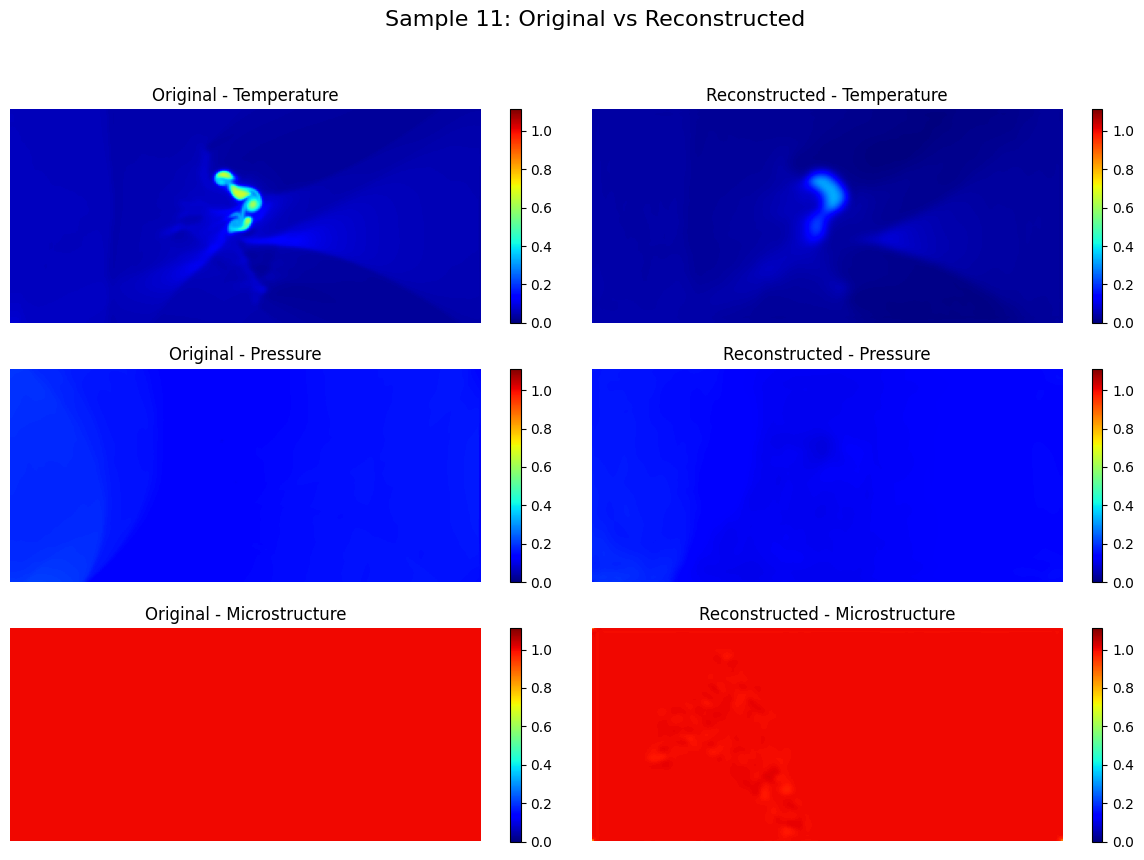

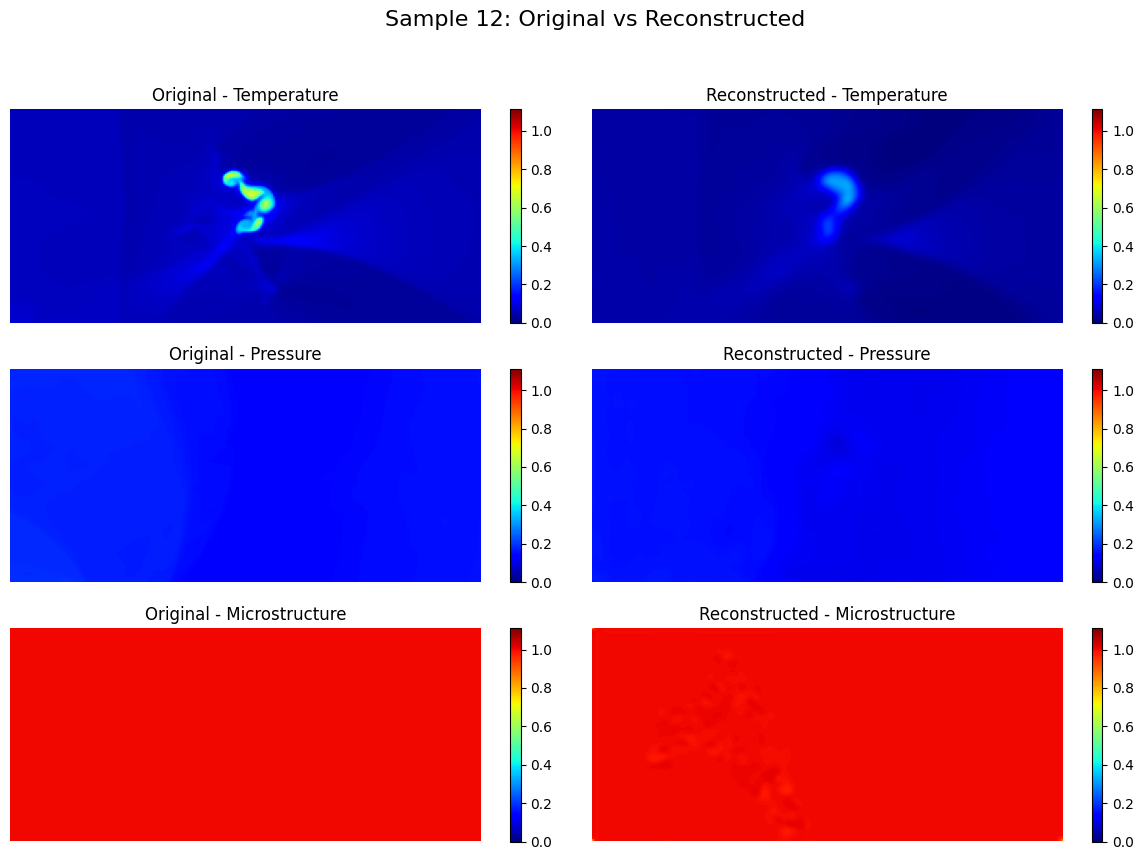

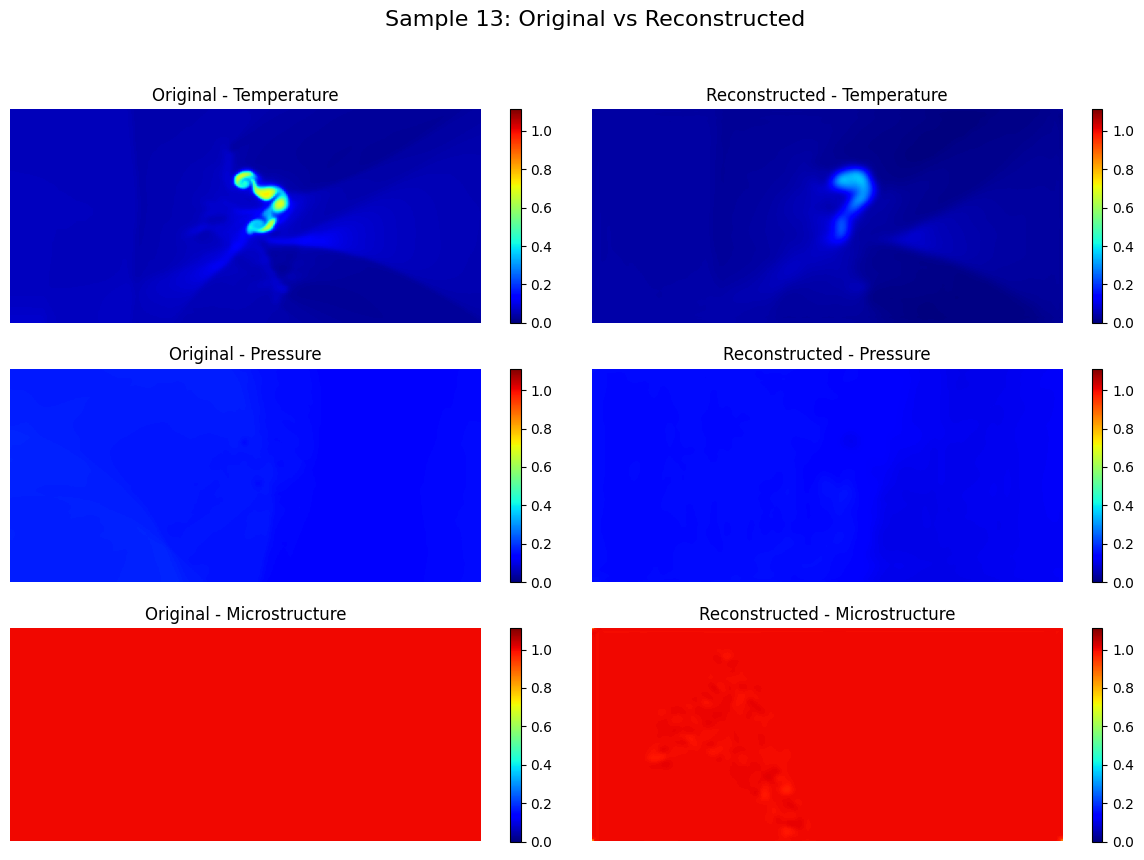

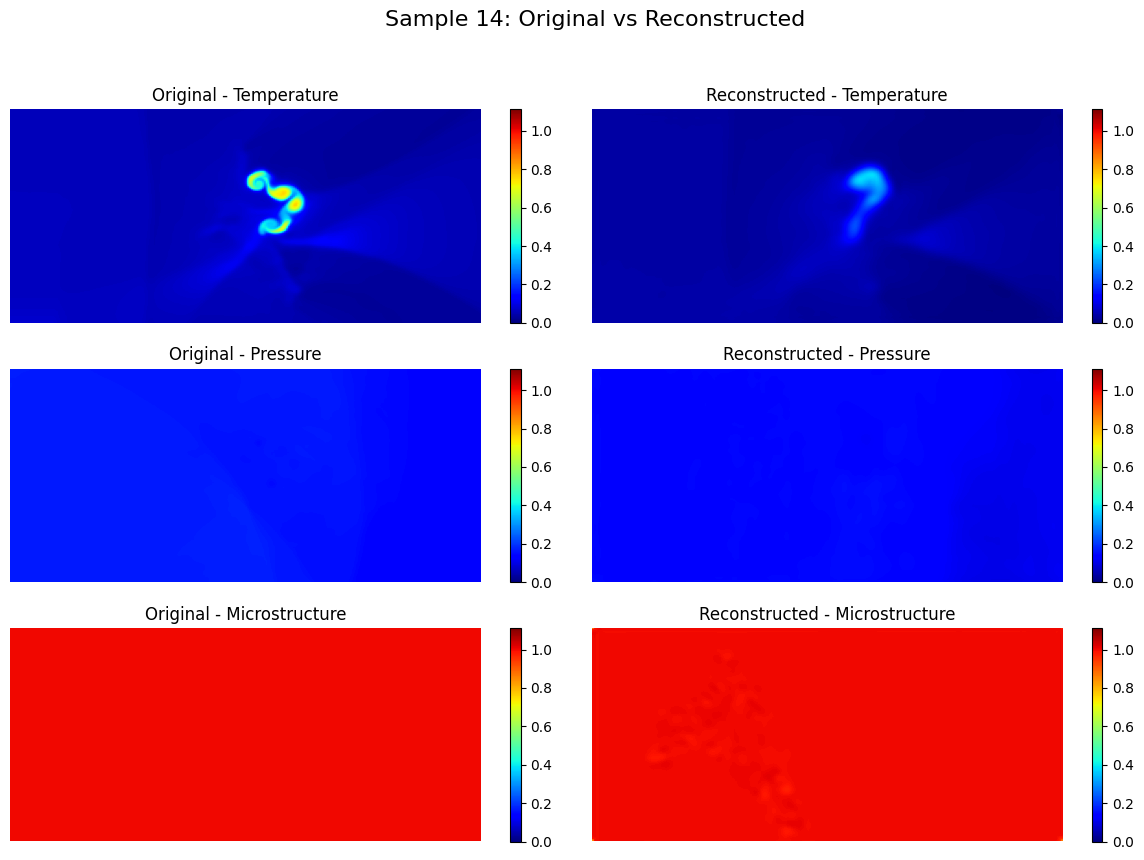

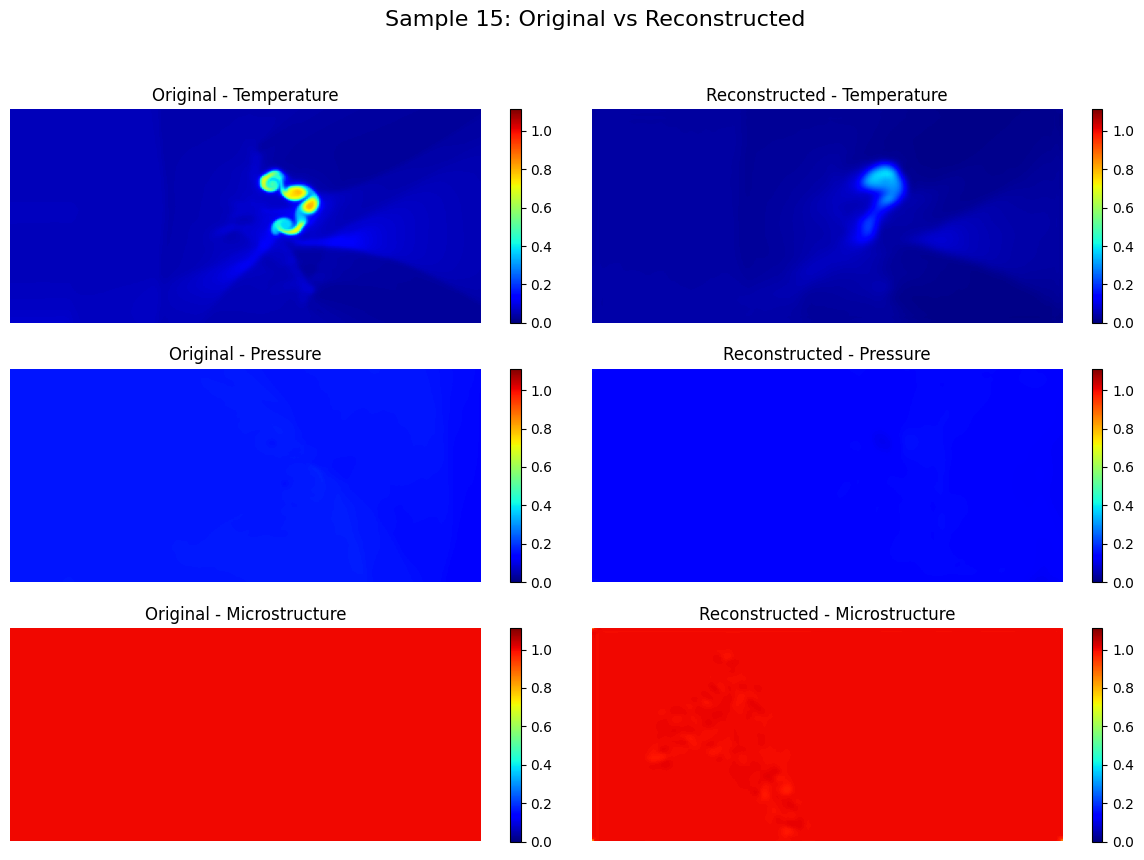

In [13]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

num_samples = 15 

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(decoded.min(), X.min())
global_max = max(decoded.max(), X.max())

# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = X[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = decoded[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()

### GIF

In [14]:
from PIL import Image

file_name = "rollout_rollout_train_nts_5_FROZEN_3enc_3dec_vertflip_ReLU_normal_conv_ReLU_out_layers_1_2_latent_6_NONOISE_LRplateau_factor8_pat10_1000"
plot_name = "Single ts Prediction, 1 Encoder 1 Decoder, no purple loss Layers 3 8, Latent Dim 16, 2 Test Samples, 3000 Epochs"

# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
# num_samples = min(28, single_ts_full_reconstruction_GT.shape[0])  # Display up to 30 samples or fewer if dataset is smaller
num_samples = n_ts

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(X.min(), decoded.min())
global_max = max(X.max(), decoded.max())

frames = []  # List to store frames for GIF

# Iterate over the selected samples (each sample represents a time step)
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(2, 3, figsize=(6, 4), dpi=150, constrained_layout=True)  # Reduced figsize and dpi for smaller GIF
    fig.suptitle(plot_name, fontsize=12)  # Reduced font size for title
    
    for channel_idx, channel_name in enumerate(channel_names):
        original_channel = X[sample_idx, channel_idx, :, :].numpy()
        reconstructed_channel = decoded[sample_idx, channel_idx, :, :].numpy()
        
        # Plot original
        ax = axes[0, channel_idx]
        ax.imshow(original_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (GT)", fontsize=10)  # Smaller title font size
        ax.axis("off")
        
        # Plot reconstructed
        ax = axes[1, channel_idx]
        ax.imshow(reconstructed_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (Pred)", fontsize=10)  # Smaller title font size
        ax.axis("off")
    
    # Convert the figure to a PIL Image and append to frames
    fig.canvas.draw()  # Draw the figure onto the canvas
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Reshape to image dimensions
    frames.append(Image.fromarray(img))

    plt.close(fig)

# Check if frames are created successfully
if len(frames) == 0:
    print("Error: No frames generated!")
else:
    # Save frames as GIF
    gif_path = file_name + ".gif"
    try:
        frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)
        print(f"GIF saved to {gif_path}")
    except Exception as e:
        print(f"Error saving GIF: {e}")


/tmp/ipykernel_562699/2349044819.py:42: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved to rollout_rollout_train_nts_5_FROZEN_3enc_3dec_vertflip_ReLU_normal_conv_ReLU_out_layers_1_2_latent_6_NONOISE_LRplateau_factor8_pat10_1000.gif


### z viz

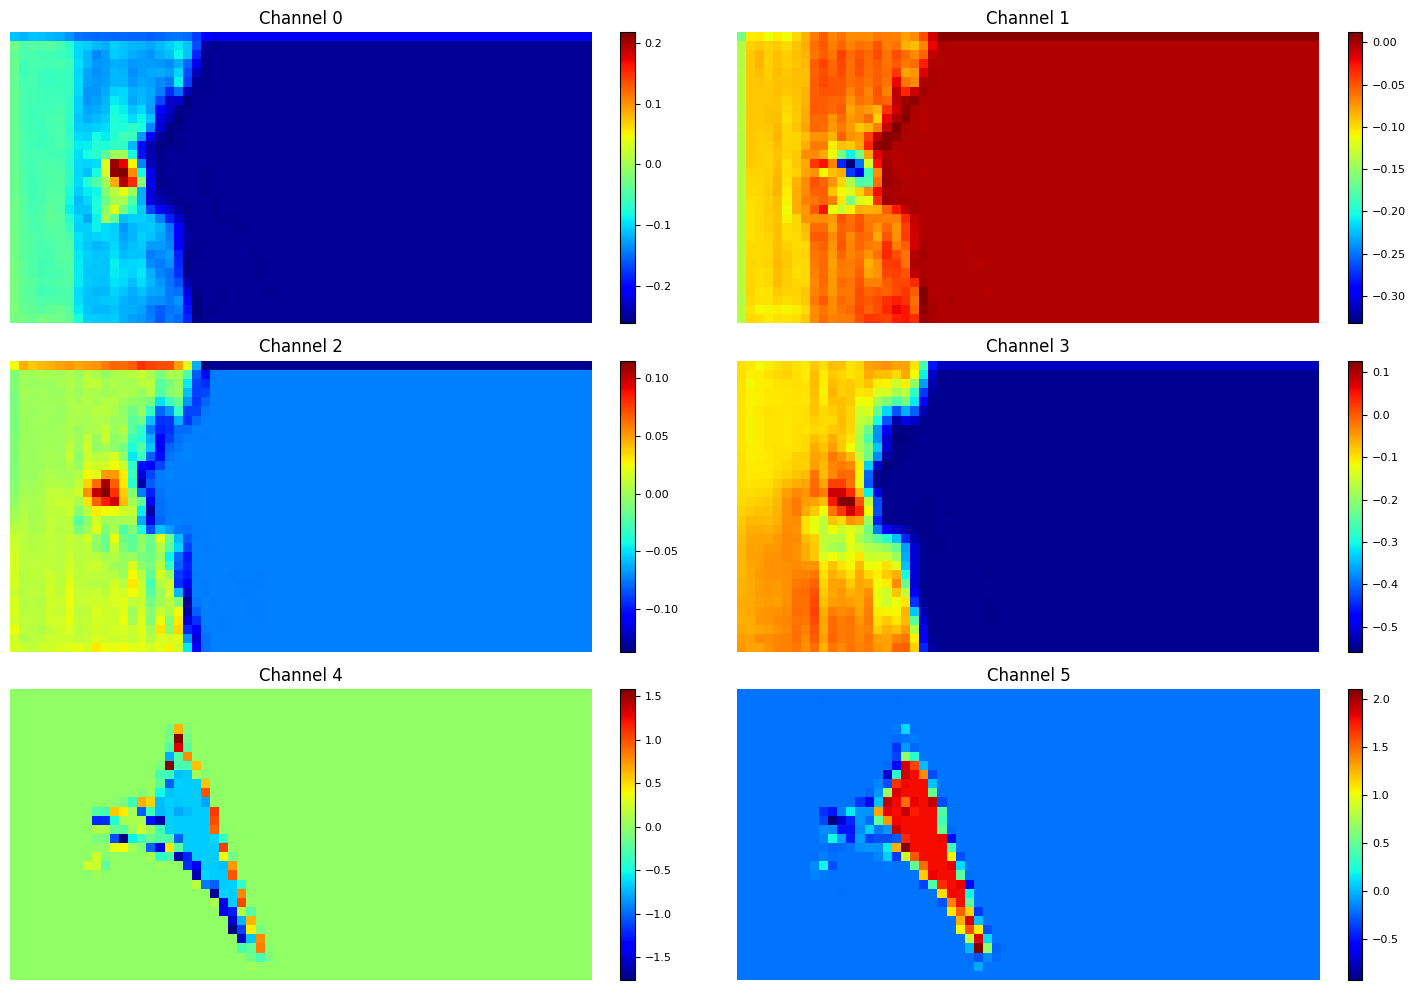

In [48]:
# select timestep to view
ts = 5
latent_dim = 2
n_latent_channels = latent_dim * 3

# Extract the 16-channel image at timestep ts
images = z[ts, ...]

# Convert to CPU and numpy for visualization
images = images.cpu().detach().numpy()

# Plot all 16 channels in a 4x4 grid with colorbars
fig, axes = plt.subplots(3, latent_dim, figsize=(15, 10))

for idx, ax in enumerate(axes.flat):
    if idx < n_latent_channels:
        im = ax.imshow(images[idx], cmap="jet")
        ax.set_title(f"Channel {idx}")
        ax.axis("off")

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)  # Adjust tick label size

plt.tight_layout()
plt.show()

### GIF

In [15]:
import imageio

file_save_name = "test"
frames = []

# Step 1: Compute per-channel vmin and vmax across all timesteps
all_data = z.cpu().detach().numpy()  # Shape: (timesteps, latent_dim, H, W)
channel_vmin = all_data.min(axis=(0, 2, 3))  
channel_vmax = all_data.max(axis=(0, 2, 3))  

print("Per-channel vmin and vmax computed.")

# Step 2: Create GIF frames
for ts in range(n_ts - 1):
    images = all_data[ts]  # Shape: (16, H, W)

    fig, axes = plt.subplots(3, latent_dim, figsize=(15, 10))

    for idx, ax in enumerate(axes.flat):
        if idx < n_latent_channels:
            im = ax.imshow(
                images[idx],
                cmap="jet",
                vmin=channel_vmin[idx],
                vmax=channel_vmax[idx]
            )
            ax.set_title(f"Channel {idx}")
            ax.axis("off")

            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()

    # Save frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frame = frame[..., :3]  # Remove alpha channel
    frames.append(frame)

    plt.close(fig)

# Step 3: Save GIF with infinite loop and longer duration
imageio.mimsave(
    f'{file_save_name}.gif',
    frames,
    duration=500,
    loop=0
)

print(f"GIF saved as '{file_save_name}.gif'")

Per-channel vmin and vmax computed.
GIF saved as 'test.gif'


# Loss Plots

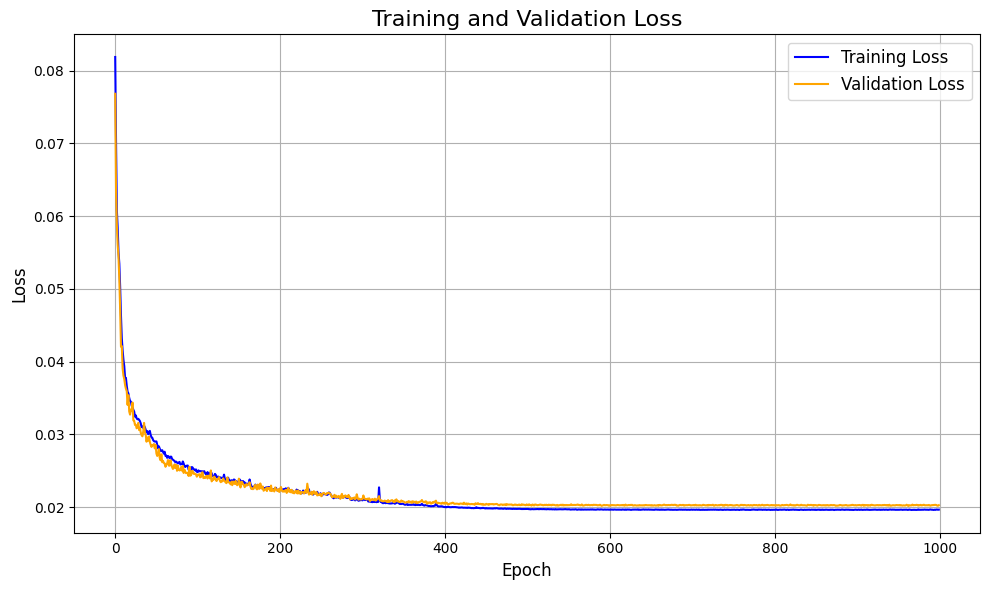

In [15]:
# Path to the JSON log file
log_file_path = "rollout_train_nts_5_FROZEN_3enc_3dec_vertflip_ReLU_normal_conv_ReLU_out_layers_1_2_latent_6_NONOISE_LRplateau_factor8_pat10_1000.json"

# Load the log data
with open(log_file_path, 'r') as f:
    log_dict = json.load(f)

# Extract training and validation loss
training_loss = log_dict['training_loss_per_epoch']
validation_loss = log_dict['validation_loss_per_epoch']

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title("Training and Validation Loss", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

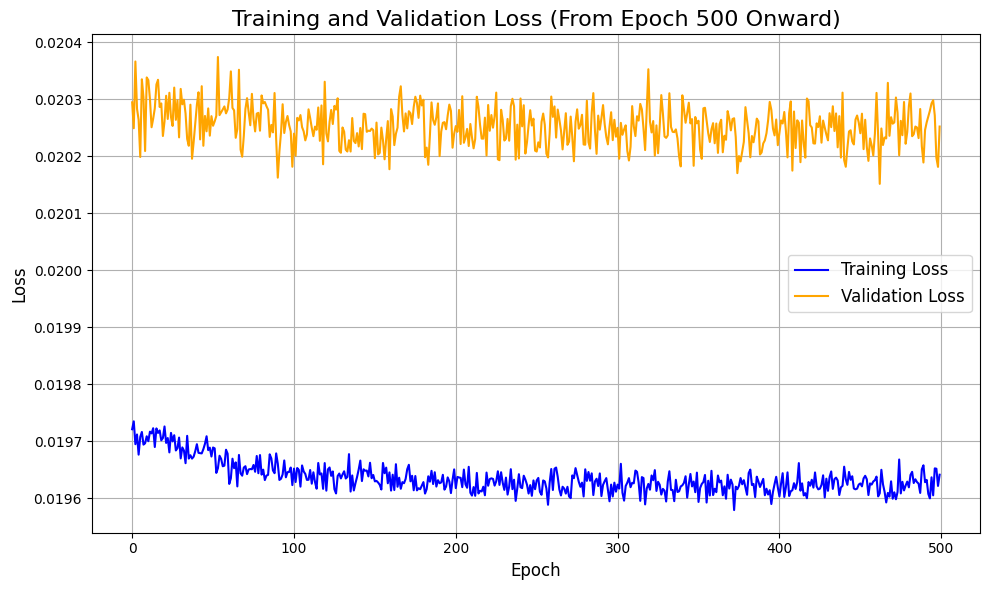

In [16]:
# Starting from the 50th epoch (index 49, since indexing starts at 0)
start_epoch = 500

# Slice the data from the 50th epoch onward
training_loss = training_loss[start_epoch:]
validation_loss = validation_loss[start_epoch:]

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title(f"Training and Validation Loss (From Epoch {start_epoch} Onward)", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


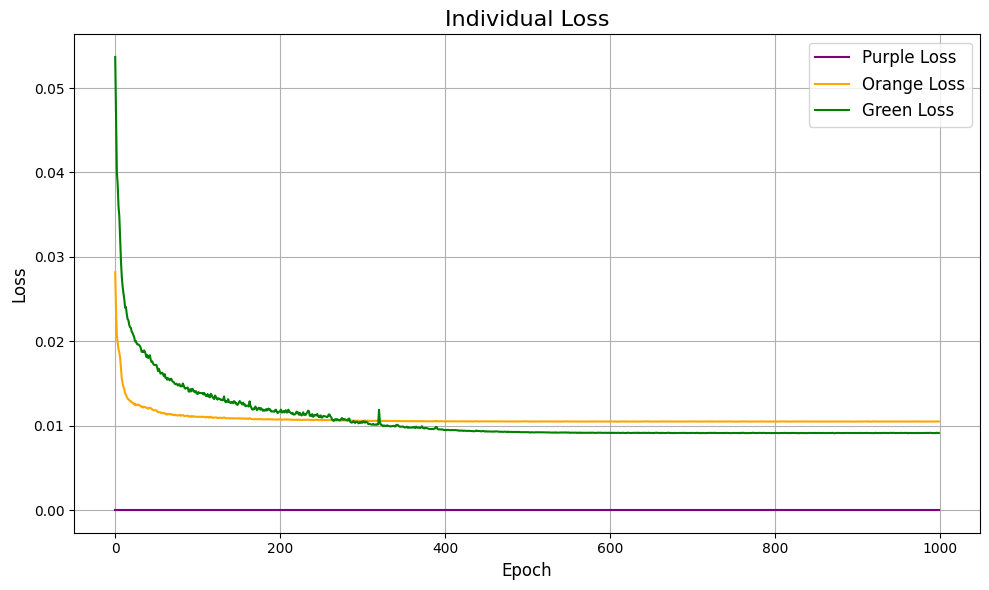

In [17]:
# Load the log data
with open(log_file_path, 'r') as f:
    log_dict = json.load(f)

# Extract training and validation loss
purple_loss = log_dict['purple_loss_train']
orange_loss = log_dict['orange_loss_train']
green_loss = log_dict['green_loss_train']

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(purple_loss, label="Purple Loss", color="purple")
ax.plot(orange_loss, label="Orange Loss", color="orange")
ax.plot(green_loss, label="Green Loss", color="green")

# Add titles, labels, and legend
ax.set_title("Individual Loss", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Norm Comparison

### Stacking All Samples

In [5]:
# single ts predictions

n_samples = 33

# load in test dataset with full 15ts sequence
n_channels = 3
n_ts = 15

# Create test dataset
# ic, t0, t1, gt
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test], #test
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

all_X = []
all_just_AE_reconstruction = []
all_just_AE_z = []
all_single_ts_Zhat = []
all_single_ts_full_reconstruction_pred = []

for i in range(n_samples):
    ic, _, ts, target = test_dataset[i]
    ic = ic[:n_channels, ...]
    target = target[:, :n_channels, ...]
 
    X = torch.concat((ic.unsqueeze(0), target))
    
    n_ts = 15

    just_AE_reconstruction = []
    just_AE_z = []
    single_ts_Zhat = []
    single_ts_full_reconstruction_pred = []

    for t in range(n_ts-1):
        IC = X[t, ...].unsqueeze(0).to(device)
        target = X[t+1, ...].unsqueeze(0).to(device)

        with torch.no_grad():
            # Reconstructing test images
            z_nodynamics, x_bar = model.network(IC, n_ts=0) # just AE
            z_hat, x_hat = model.network(IC, n_ts=1) # AE + dynamics

        # Sending reconstructed and original images to CPU and accumulating in lists
        just_AE_reconstruction.append(x_bar.cpu())
        just_AE_z.append(z_nodynamics.cpu())
        single_ts_Zhat.append(z_hat.cpu())
        single_ts_full_reconstruction_pred.append(x_hat.cpu())

    # Get last timestep for z_nodynamics
    z_nodynamics, x_bar = model.network(X[n_ts-1, ...].unsqueeze(0).to(device), n_ts=0) # just AE
    just_AE_reconstruction.append(x_bar.cpu())
    just_AE_z.append(z_nodynamics.cpu())

    # Concatenate all batches to create single tensors
    just_AE_reconstruction = torch.cat(just_AE_reconstruction, dim=0)
    just_AE_z = torch.cat(just_AE_z, dim=0)

    single_ts_Zhat = torch.cat(single_ts_Zhat, dim=0)  # Shape: (total_images, n_channels, height, width)
    single_ts_full_reconstruction_pred = torch.cat(single_ts_full_reconstruction_pred, dim=0)
    
    all_X.append(X)
    all_just_AE_reconstruction.append(just_AE_reconstruction)
    all_just_AE_z.append(just_AE_z)
    all_single_ts_Zhat.append(single_ts_Zhat)
    all_single_ts_full_reconstruction_pred.append(single_ts_full_reconstruction_pred)

all_X = torch.stack(all_X, dim=0)  # Shape: (n_samples, time_steps, channels, height, width)
all_just_AE_reconstruction = torch.stack(all_just_AE_reconstruction, dim=0)  # Shape: (n_samples, time_steps, channels, height, width)
all_just_AE_z = torch.stack(all_just_AE_z, dim=0)  # Shape: (n_samples, time_steps, channels, height, width)
all_single_ts_Zhat = torch.stack(all_single_ts_Zhat, dim=0)
all_single_ts_full_reconstruction_pred = torch.stack(all_single_ts_full_reconstruction_pred, dim=0)

2025-05-21 10:06:37,416 [INFO] Starting data validation...
2025-05-21 10:06:37,420 [INFO] Validating .npy files...
Validating files: 100%|██████████| 33/33 [00:00<00:00, 680.39it/s]
2025-05-21 10:06:37,475 [INFO] Data validation completed successfully.
2025-05-21 10:06:37,476 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 33/33 [00:00<00:00, 724.48it/s]
2025-05-21 10:06:37,526 [INFO] Total samples in dataset: 33


In [ ]:
# rollout predictions
n_samples = 33

# load in test dataset with full 15ts sequence
n_channels = 3
n_ts = 15

# Create test dataset
# ic, t0, t1, gt
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test], #test
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

all_X = []
all_z = []
all_decoded = []

for i in range(n_samples):
    ic, _, ts, target = test_dataset[i]
    ic = ic[:n_channels, ...]
    target = target[:, :n_channels, ...]

    X = torch.concat((ic.unsqueeze(0), target))
    
    with torch.no_grad():
        z, decoded = model_init(ic.unsqueeze(0).to(device), n_ts=n_ts, mode='pred')

    z = z.squeeze(1).cpu()
    decoded = decoded.squeeze(1).cpu()

    all_X.append(X)
    all_z.append(z)
    all_decoded.append(decoded)
    
all_X = torch.stack(all_X, dim=0)  # Shape: (n_samples, time_steps, channels, height, width)
all_z = torch.stack(all_z, dim=0)  # Shape: (n_samples, time_steps, channels, height, width)
all_decoded = torch.stack(all_decoded, dim=0)  # Shape: (n_samples, time_steps, channels, height, width)


### No Dynamics

In [6]:
all_input_norm, all_latent_norm, all_reconstruction_norm = [], [], []
all_separate_input_norm, all_separate_reconstruction_norm = [], []

for i in range(n_samples):
    X_diff = compute_finite_difference(all_X[i, ...])
    reconstruction_diff = compute_finite_difference(all_just_AE_reconstruction[i, ...])
    z_diff = compute_finite_difference(all_just_AE_z[i, ...])

    input_norm, latent_norm, reconstruction_norm = calculate_norm(X_diff, z_diff, reconstruction_diff)
    separate_input_norm, separate_reconstruction_norm = calculate_separate_norm(X_diff, reconstruction_diff)
    
    all_input_norm.append(input_norm)
    all_latent_norm.append(latent_norm)
    all_reconstruction_norm.append(reconstruction_norm)
    
    all_separate_input_norm.append(separate_input_norm)
    all_separate_reconstruction_norm.append(separate_reconstruction_norm)

In [7]:
all_latent_ratio = []
all_reconstruction_ratio = []

for i in range(n_samples):  
    latent_ratio =  np.array(all_latent_norm[i]) / np.array(all_input_norm[i])
    reconstruction_ratio = np.array(all_reconstruction_norm[i]) / np.array(all_input_norm[i])
    
    all_latent_ratio.append(latent_ratio)
    all_reconstruction_ratio.append(reconstruction_ratio)

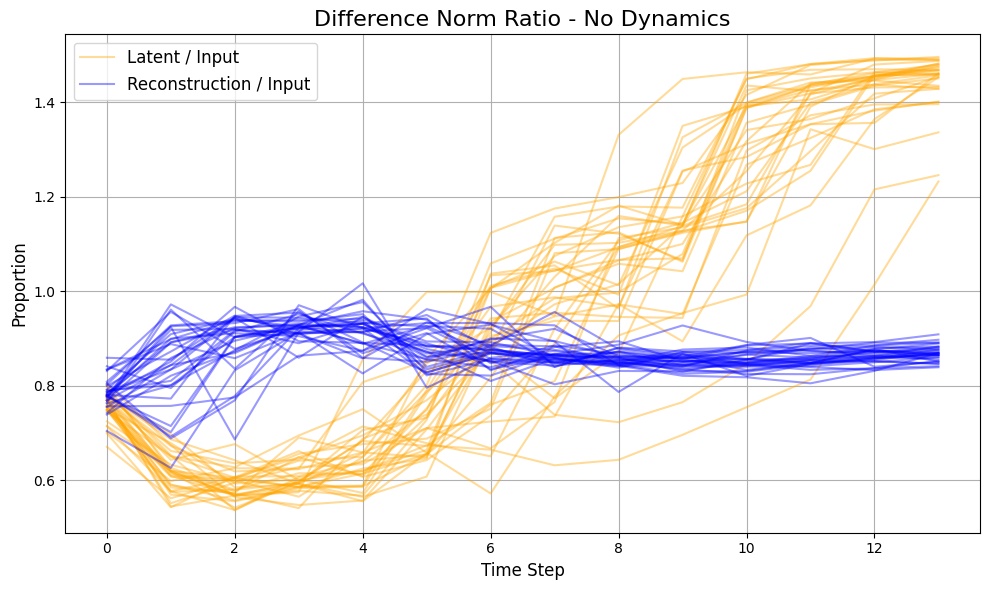

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all latent ratios (orange, 60% transparent)
for i, latent in enumerate(all_latent_ratio):
    ax.plot(latent, color="orange", alpha=0.4, label="Latent / Input" if i == 0 else None)

# Plot all reconstruction ratios (blue, 60% transparent)
for i, recon in enumerate(all_reconstruction_ratio):
    ax.plot(recon, color="blue", alpha=0.4, label="Reconstruction / Input" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Norm Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()


In [9]:
all_temp_ratio, all_pressure_ratio, all_ms_ratio = [], [], []

for i in range(n_samples):
    temp_ratio = all_separate_reconstruction_norm[i][:,0] / all_separate_input_norm[i][:,0]
    pressure_ratio = all_separate_reconstruction_norm[i][:,1] / all_separate_input_norm[i][:,1]
    # ms_ratio = separate_reconstruction_norm[:,2] / separate_input_norm[:,2]
    with np.errstate(divide='ignore', invalid='ignore'):
        ms_ratio = all_separate_reconstruction_norm[i][:,2] / all_separate_input_norm[i][:,2]
        ms_ratio[np.isnan(ms_ratio)] = 1.0  # replace only nan (e.g. 0/0) with 1
        ms_ratio[np.isinf(ms_ratio)] = 1.0  # optional: replace inf with 0
    
    all_temp_ratio.append(temp_ratio)
    all_pressure_ratio.append(pressure_ratio)
    all_ms_ratio.append(ms_ratio)

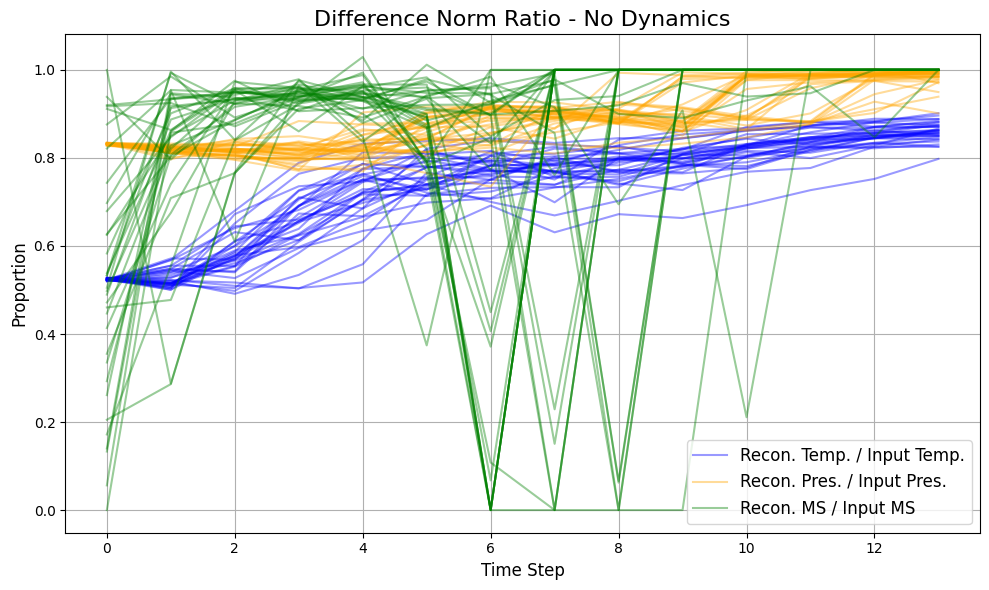

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

# can comment out any for loop to viz separate

# Plot all temperature ratios (blue, 60% transparent)
for i, temp in enumerate(all_temp_ratio):
    ax.plot(temp, color="blue", alpha=0.4, label="Recon. Temp. / Input Temp." if i == 0 else None)

# Plot all pressure ratios (orange, 60% transparent)
for i, pres in enumerate(all_pressure_ratio):
    ax.plot(pres, color="orange", alpha=0.4, label="Recon. Pres. / Input Pres." if i == 0 else None)

# Plot all MS ratios (green, 60% transparent)
for i, ms in enumerate(all_ms_ratio):
    ax.plot(ms, color="green", alpha=0.4, label="Recon. MS / Input MS" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Norm Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()


In [11]:
all_input_dot, all_latent_dot, all_reconstruction_dot = [], [], []
# all_separate_input_dot, all_separate_reconstruction_dot = [], []

for i in range(n_samples):
    X_diff = compute_finite_difference(all_X[i, ...])
    reconstruction_diff = compute_finite_difference(all_just_AE_reconstruction[i, ...])
    z_diff = compute_finite_difference(all_just_AE_z[i, ...])

    input_dot = compute_pairwise_dot_product(X_diff)
    latent_dot = compute_pairwise_dot_product(z_diff)
    reconstruction_dot = compute_pairwise_dot_product(reconstruction_diff)
    # separate_input_dot = compute_pairwise_dot_product(X_diff)
    # separate_reconstruction_dot = calculate_separate_norm(X_diff, reconstruction_diff)
    
    all_input_dot.append(input_dot)
    all_latent_dot.append(latent_dot)
    all_reconstruction_dot.append(reconstruction_dot)
    
    # all_separate_input_norm.append(separate_input_norm)
    # all_separate_reconstruction_norm.append(separate_reconstruction_norm)

In [12]:
all_latent_ratio = []
all_reconstruction_ratio = []

for i in range(n_samples):  
    latent_ratio =  np.array(all_latent_dot[i]) / np.array(all_input_dot[i])
    reconstruction_ratio = np.array(all_reconstruction_dot[i]) / np.array(all_input_dot[i])
    
    all_latent_ratio.append(latent_ratio)
    all_reconstruction_ratio.append(reconstruction_ratio)

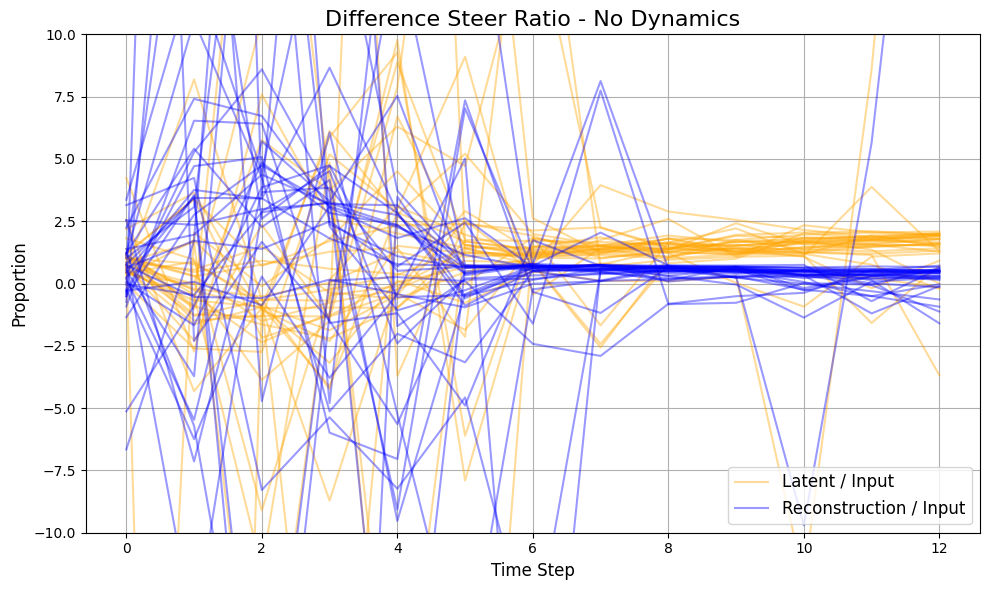

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all latent ratios (orange, 60% transparent)
for i, latent in enumerate(all_latent_ratio):
    ax.plot(latent, color="orange", alpha=0.4, label="Latent / Input" if i == 0 else None)

# Plot all reconstruction ratios (blue, 60% transparent)
for i, recon in enumerate(all_reconstruction_ratio):
    ax.plot(recon, color="blue", alpha=0.4, label="Reconstruction / Input" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Steer Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

ax.set_ylim(-10, 10)  # Adjust range to focus on relevant data (change 0 and 2 as needed)

plt.tight_layout()
plt.show()


### Single TS Pred

In [16]:
all_input_norm, all_latent_norm, all_reconstruction_norm = [], [], []
all_separate_input_norm, all_separate_reconstruction_norm = [], []

for i in range(n_samples):
    X_diff = compute_finite_difference(all_X[i, 1:, ...])
    reconstruction_diff = compute_finite_difference(all_single_ts_full_reconstruction_pred[i, ...])
    z_diff = compute_finite_difference(all_single_ts_Zhat[i, ...])

    input_norm, latent_norm, reconstruction_norm = calculate_norm(X_diff, z_diff, reconstruction_diff)
    separate_input_norm, separate_reconstruction_norm = calculate_separate_norm(X_diff, reconstruction_diff)
    
    all_input_norm.append(input_norm)
    all_latent_norm.append(latent_norm)
    all_reconstruction_norm.append(reconstruction_norm)
    
    all_separate_input_norm.append(separate_input_norm)
    all_separate_reconstruction_norm.append(separate_reconstruction_norm)


In [17]:
all_latent_ratio = []
all_reconstruction_ratio = []

for i in range(n_samples):  
    latent_ratio =  np.array(all_latent_norm[i]) / np.array(all_input_norm[i])
    reconstruction_ratio = np.array(all_reconstruction_norm[i]) / np.array(all_input_norm[i])
    
    all_latent_ratio.append(latent_ratio)
    all_reconstruction_ratio.append(reconstruction_ratio)

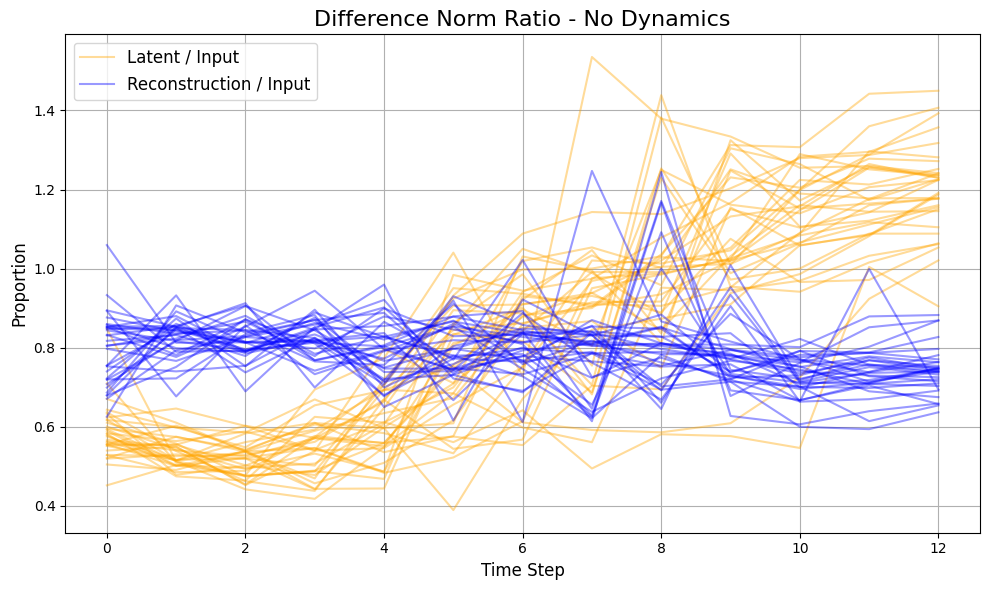

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all latent ratios (orange, 60% transparent)
for i, latent in enumerate(all_latent_ratio):
    ax.plot(latent, color="orange", alpha=0.4, label="Latent / Input" if i == 0 else None)

# Plot all reconstruction ratios (blue, 60% transparent)
for i, recon in enumerate(all_reconstruction_ratio):
    ax.plot(recon, color="blue", alpha=0.4, label="Reconstruction / Input" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Norm Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()


In [19]:
all_temp_ratio, all_pressure_ratio, all_ms_ratio = [], [], []

for i in range(n_samples):
    temp_ratio = all_separate_reconstruction_norm[i][:,0] / all_separate_input_norm[i][:,0]
    pressure_ratio = all_separate_reconstruction_norm[i][:,1] / all_separate_input_norm[i][:,1]
    # ms_ratio = separate_reconstruction_norm[:,2] / separate_input_norm[:,2]
    with np.errstate(divide='ignore', invalid='ignore'):
        ms_ratio = all_separate_reconstruction_norm[i][:,2] / all_separate_input_norm[i][:,2]
        ms_ratio[np.isnan(ms_ratio)] = 1.0  # replace only nan (e.g. 0/0) with 1
        ms_ratio[np.isinf(ms_ratio)] = 1.0  # optional: replace inf with 0
    
    all_temp_ratio.append(temp_ratio)
    all_pressure_ratio.append(pressure_ratio)
    all_ms_ratio.append(ms_ratio)

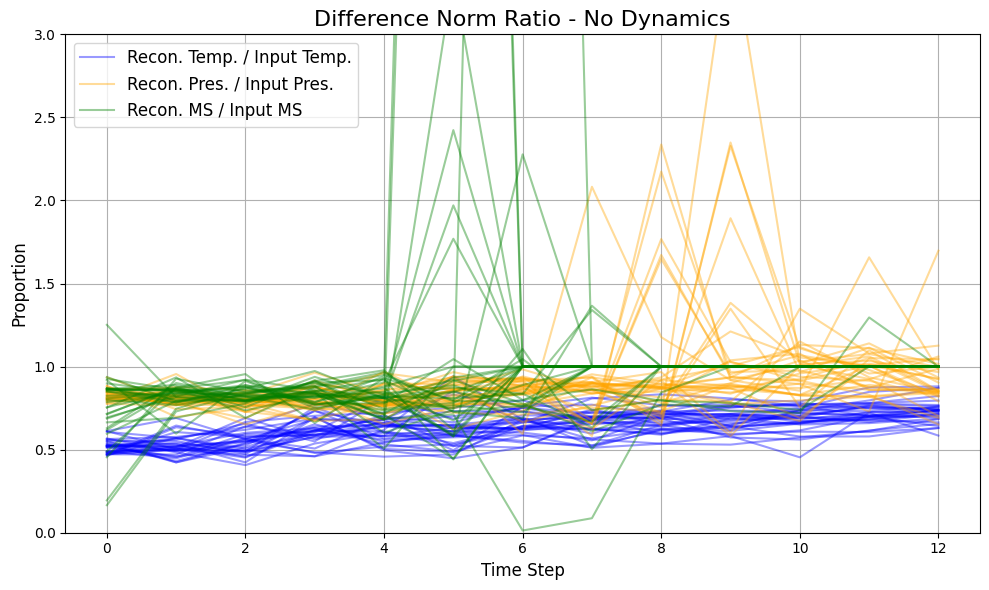

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

# can comment out any for loop to viz separate

# Plot all temperature ratios (blue, 60% transparent)
for i, temp in enumerate(all_temp_ratio):
    ax.plot(temp, color="blue", alpha=0.4, label="Recon. Temp. / Input Temp." if i == 0 else None)

# Plot all pressure ratios (orange, 60% transparent)
for i, pres in enumerate(all_pressure_ratio):
    ax.plot(pres, color="orange", alpha=0.4, label="Recon. Pres. / Input Pres." if i == 0 else None)

# Plot all MS ratios (green, 60% transparent)
for i, ms in enumerate(all_ms_ratio):
    ax.plot(ms, color="green", alpha=0.4, label="Recon. MS / Input MS" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Norm Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)


ax.set_ylim(0, 3)  # Adjust range to focus on relevant data (change 0 and 2 as needed)

plt.tight_layout()
plt.show()


In [22]:
all_input_dot, all_latent_dot, all_reconstruction_dot = [], [], []
# all_separate_input_dot, all_separate_reconstruction_dot = [], []

for i in range(n_samples):
    X_diff = compute_finite_difference(all_X[i, 1:, ...])
    reconstruction_diff = compute_finite_difference(all_single_ts_full_reconstruction_pred[i, ...])
    z_diff = compute_finite_difference(all_single_ts_Zhat[i, ...])

    input_dot = compute_pairwise_dot_product(X_diff)
    latent_dot = compute_pairwise_dot_product(z_diff)
    reconstruction_dot = compute_pairwise_dot_product(reconstruction_diff)
    # separate_input_dot = compute_pairwise_dot_product(X_diff)
    # separate_reconstruction_dot = calculate_separate_norm(X_diff, reconstruction_diff)
    
    all_input_dot.append(input_dot)
    all_latent_dot.append(latent_dot)
    all_reconstruction_dot.append(reconstruction_dot)

In [23]:
all_latent_ratio = []
all_reconstruction_ratio = []

for i in range(n_samples):  
    latent_ratio =  np.array(all_latent_dot[i]) / np.array(all_input_dot[i])
    reconstruction_ratio = np.array(all_reconstruction_dot[i]) / np.array(all_input_dot[i])
    
    all_latent_ratio.append(latent_ratio)
    all_reconstruction_ratio.append(reconstruction_ratio)

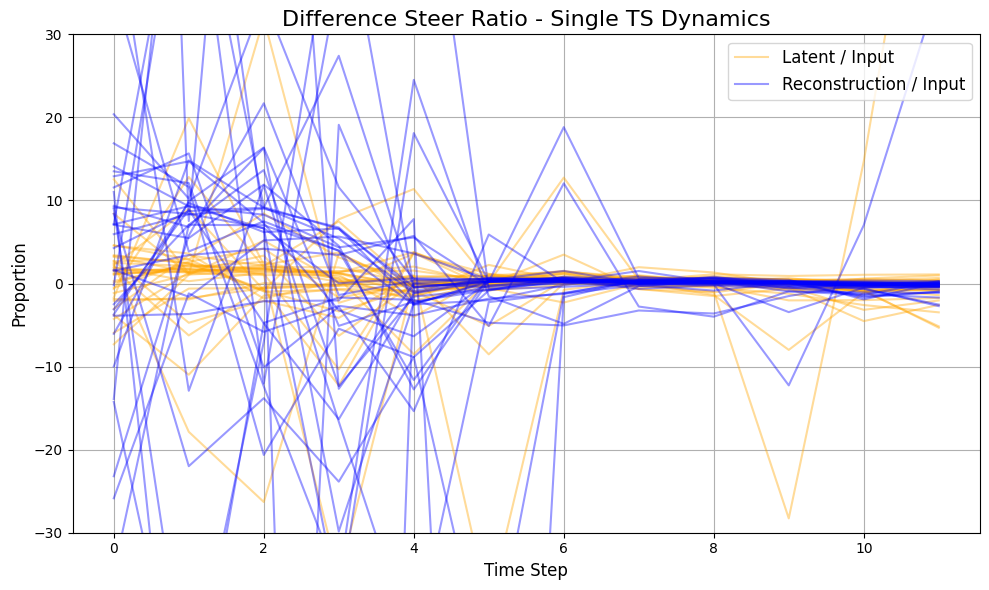

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all latent ratios (orange, 60% transparent)
for i, latent in enumerate(all_latent_ratio):
    ax.plot(latent, color="orange", alpha=0.4, label="Latent / Input" if i == 0 else None)

# Plot all reconstruction ratios (blue, 60% transparent)
for i, recon in enumerate(all_reconstruction_ratio):
    ax.plot(recon, color="blue", alpha=0.4, label="Reconstruction / Input" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Steer Ratio - Single TS Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

ax.set_ylim(-30, 30)  # Adjust range to focus on relevant data (change 0 and 2 as needed)

plt.tight_layout()
plt.show()
